# Integration: MaxFuse and MARIO

This notebook performs cross-modal integration of RNA-seq and CODEX protein data.

## Recommended Workflow

**For cross-modal data (RNA + Protein/CODEX):**
1. Run Steps 1-4 (data loading and preparation)
2. **Skip** MARIO section (designed for same-modality data)
3. Run **MaxFuse Integration** (Step 7+)

**For same-modality data (e.g., CITE-seq + CyTOF):**
1. Run all steps including MARIO

## What Each Method Does

| Method | Best For | Key Feature |
|--------|----------|-------------|
| **MaxFuse** | Cross-modal (RNA↔Protein) | Handles weak feature linkage |
| **MARIO** | Same-modality (Protein↔Protein) | Statistical matchability test |


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import json
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import mmread

# MaxFuse imports
import maxfuse as mf
from maxfuse import Fusor, Mario
from maxfuse.mario import pipelined_mario

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load preprocessed data from 1_preprocessing.ipynb
# Run 1_preprocessing.ipynb first to generate these files

import os

results_dir = '../results/1_preprocessing'

if not os.path.exists(results_dir):
    raise FileNotFoundError(
        f"Results directory '{results_dir}' not found. "
        f"Run 1_preprocessing.ipynb first to generate the input files."
    )

# Load processed AnnData objects
protein_adata = sc.read_h5ad(f'{results_dir}/protein_adata.h5ad')
rna_adata = sc.read_h5ad(f'{results_dir}/rna_adata.h5ad')
rna_adata_lognorm = sc.read_h5ad(f'{results_dir}/rna_adata_lognorm.h5ad')

print(f"Loaded from {results_dir}/")
print(f"  Protein data: {protein_adata.shape}")
print(f"  RNA data: {rna_adata.shape}")
print(f"  RNA log-normalized: {rna_adata_lognorm.shape}")

# Load preprocessing parameters
with open(f'{results_dir}/preprocessing_params.json', 'r') as f:
    preprocess_params = json.load(f)
print(f"\nPreprocessing timestamp: {preprocess_params['timestamp']}")

Loaded from results/1_preprocessing/
  Protein data: (1740774, 59)
  RNA data: (1284, 15887)
  RNA log-normalized: (1284, 15887)

Preprocessing timestamp: 2026-01-16T14:47:28.211987


## Step 3: Build Protein-Gene Correspondence

Map CODEX protein markers to their corresponding gene names in the RNA data.

In [3]:
# Load correspondence table
correspondence = pd.read_csv('../data/protein_gene_conversion.csv', encoding='utf-8-sig')
print(f"Correspondence table: {correspondence.shape[0]} entries")
correspondence.head(10)

Correspondence table: 370 entries


,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG
5,CD275-1,ICOSLG
6,CD275-2,ICOSLG
7,CD11b,ITGAM
8,CD11b-1,ITGAM
9,CD11b-2,ITGAM


In [4]:
# Find matching features between CODEX markers and RNA genes
rna_protein_correspondence = []
unmatched_proteins = []

for marker in protein_adata.var_names:
    # Skip DAPI and ECAD (not useful for cell type matching)
    if marker in ['DAPI', 'ECAD', 'IAPP', 'Ker8-18','Pan-Cytokeratin','E-cadherin',  'Collagen IV','Vimentin', 'Caveolin', 'Keratin 5','Beta-actin','LAG3', 'TP63', 'CD31', 'SMA','Podoplanin', 'SOX2']:
        continue
    
    # Look up in correspondence table
    matches = correspondence[correspondence['Protein name'].str.lower() == marker.lower()]
    
    if len(matches) == 0:
        # Try alternative names
        alt_names = {
            'CD3e': 'CD3',
            'FoxP3': 'FOXP3',
            'HLADR': 'HLA-DR',
            'Lyve1': 'LYVE1',
            'SMActin': 'SMA',
            'CollagenIV': 'collagen IV',
        }
        alt_marker = alt_names.get(marker, marker)
        matches = correspondence[correspondence['Protein name'].str.lower() == alt_marker.lower()]
    
    if len(matches) > 0:
        rna_names_str = matches.iloc[0]['RNA name']
        if 'Ignore' in str(rna_names_str):
            unmatched_proteins.append((marker, 'Ignored'))
            continue
        
        # Try each RNA name option
        found = False
        for rna_name in str(rna_names_str).split('/'):
            if rna_name in rna_adata.var_names:
                rna_protein_correspondence.append([rna_name, marker])
                found = True
                break
        if not found:
            unmatched_proteins.append((marker, rna_names_str))
    else:
        unmatched_proteins.append((marker, 'Not in table'))

rna_protein_correspondence = np.array(rna_protein_correspondence)
print(f"Found {len(rna_protein_correspondence)} protein-gene pairs")

if unmatched_proteins:
    print(f"\nUnmatched proteins ({len(unmatched_proteins)}):")
    for prot, reason in unmatched_proteins:
        print(f"  {prot}: {reason}")

Found 43 protein-gene pairs


In [5]:
# Remove duplicates (same RNA mapping to multiple proteins)
# Keep first occurrence
seen_rna = set()
unique_pairs = []
for rna, prot in rna_protein_correspondence:
    if rna not in seen_rna:
        seen_rna.add(rna)
        unique_pairs.append([rna, prot])
    else:
        print(f"Removing duplicate RNA mapping: {rna} -> {prot}")

rna_protein_correspondence = np.array(unique_pairs)
print(f"\nFinal correspondence: {len(rna_protein_correspondence)} pairs")

print("\nMatched features:")
for rna, prot in rna_protein_correspondence:
    print(f"  {rna:15} <-> {prot}")


Final correspondence: 43 pairs

Matched features:
  LAMP1           <-> CD107a
  CD4             <-> CD4
  CD68            <-> CD68
  CD44            <-> CD44
  CD99            <-> CD99
  IDO1            <-> IDO1
  CEACAM1         <-> CD66
  INS             <-> INS
  ITGAX           <-> CD11c
  CD38            <-> CD38
  HLA-DRA         <-> HLA-DR
  CD34            <-> CD34
  NOS2            <-> iNOS
  LGALS3          <-> M2Gal3
  TUBB3           <-> B3TUBB
  CD8A            <-> CD8
  PCNA            <-> PCNA
  FOXP3           <-> FOXP3
  B3GAT1          <-> CD57
  MKI67           <-> Ki67
  GZMB            <-> Granzyme B
  HLA-A           <-> HLA-A
  MS4A1           <-> CD20
  VSIR            <-> VISTA
  PDCD1           <-> PD-1
  SST             <-> SST
  TCF7            <-> TCF-1
  TOX             <-> TOX
  ICOS            <-> ICOS
  CD163           <-> CD163
  EPCAM           <-> EpCAM
  CD274           <-> PD-L1
  CD79A           <-> CD79a
  CD3E            <-> CD3e
  GCG        

## Step 4: Prepare Arrays for Integration

Extract and normalize:
- **Shared arrays**: Corresponding protein/gene features (used for initial matching)
- **Active arrays**: All features (used for refinement)

In [6]:
# Extract shared features from FILTERED data
# Create AnnData objects for shared features to use with scanpy normalization

# Get the gene/protein names from correspondence
shared_rna_genes = rna_protein_correspondence[:, 0]  # RNA gene names
shared_protein_markers = rna_protein_correspondence[:, 1]  # Protein marker names

# Verify all features exist
missing_rna = [g for g in shared_rna_genes if g not in rna_adata.var_names]
missing_prot = [p for p in shared_protein_markers if p not in protein_adata.var_names]

if missing_rna:
    print(f"WARNING: Missing RNA genes: {missing_rna}")
if missing_prot:
    print(f"WARNING: Missing protein markers: {missing_prot}")

# Create shared feature AnnData objects
rna_shared_adata = rna_adata[:, shared_rna_genes].copy()
protein_shared_adata = protein_adata[:, shared_protein_markers].copy()

print(f"Shared feature AnnData objects created:")
print(f"  rna_shared_adata: {rna_shared_adata.shape}")
print(f"  protein_shared_adata: {protein_shared_adata.shape}")
print(f"\nRNA shared features: {list(rna_shared_adata.var_names[:5])}...")
print(f"Protein shared features: {list(protein_shared_adata.var_names[:5])}...")

Shared feature AnnData objects created:
  rna_shared_adata: (1284, 43)
  protein_shared_adata: (1740774, 43)

RNA shared features: ['LAMP1', 'CD4', 'CD68', 'CD44', 'CD99']...
Protein shared features: ['CD107a', 'CD4', 'CD68', 'CD44', 'CD99']...


In [7]:
# Normalize shared features - GATE-BASED DETECTION PIPELINE
# Protein detection is determined by marker-specific gates from scimap
# RNA uses standard normalization

from scipy import sparse
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ============================================================
# EXTRACT RAW DATA
# ============================================================

rna_shared_raw = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared_raw):
    rna_shared_raw = rna_shared_raw.toarray()

protein_shared_raw = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared_raw):
    protein_shared_raw = protein_shared_raw.toarray()

print("=" * 70)
print("SHARED FEATURE NORMALIZATION (GATE-BASED DETECTION)")
print("=" * 70)
print(f"\nCell counts: RNA = {rna_shared_raw.shape[0]:,}, Protein = {protein_shared_raw.shape[0]:,}")

# ============================================================
# LOAD GATES AND RAW PROTEIN VALUES
# ============================================================

# Gates are stored in protein_adata.uns['gates'] 
# Raw values are in protein_adata.layers['log'] (on same scale as gates)
gates = protein_adata.uns['gates']
protein_log_layer = protein_adata.layers['log']

print("\n" + "="*70)
print("PROTEIN GATE-BASED DETECTION")
print("="*70)

# Get gates for shared features only
shared_marker_names = [prot_name for rna_name, prot_name in rna_protein_correspondence]

# Extract log values for shared features
protein_log_shared = np.zeros((protein_shared_adata.n_obs, len(shared_marker_names)))
protein_gates = np.zeros(len(shared_marker_names))

for i, marker in enumerate(shared_marker_names):
    # Find marker index in full protein_adata
    if marker in protein_adata.var_names:
        marker_idx = list(protein_adata.var_names).index(marker)
        protein_log_shared[:, i] = protein_log_layer[:, marker_idx]
        if marker in gates.index:
            protein_gates[i] = gates.loc[marker, 'gates']
        else:
            # If no gate, use median as fallback
            protein_gates[i] = np.median(protein_log_shared[:, i])
            print(f"  WARNING: No gate for {marker}, using median: {protein_gates[i]:.2f}")

# Create detection mask: detected if log value > gate threshold
protein_detected = protein_log_shared > protein_gates[np.newaxis, :]

print(f"\nPer-marker detection rates (using gates):")
print(f"{'Marker':<12} {'Gate':>8} {'% Detected':>12}")
print("-"*34)
for i, (rna_name, prot_name) in enumerate(rna_protein_correspondence):
    det_rate = protein_detected[:, i].mean() * 100
    print(f"{prot_name[:11]:<12} {protein_gates[i]:>8.2f} {det_rate:>11.1f}%")

# ============================================================
# PROTEIN NORMALIZATION - Z-SCORE TO MATCH RNA SCALE
# ============================================================

print("\n" + "="*70)
print("PROTEIN DATA")
print("="*70)
print(f"  Shape: {protein_shared_raw.shape}")
print(f"  Before z-score:")
print(f"    Mean: {protein_shared_raw.mean():.3f}")
print(f"    Std: {protein_shared_raw.std():.3f}")
print(f"    Range: [{protein_shared_raw.min():.2f}, {protein_shared_raw.max():.2f}]")

# Z-score protein to match RNA scale
scaler = StandardScaler()
protein_shared_normalized = scaler.fit_transform(protein_shared_raw)
protein_shared_normalized = np.clip(protein_shared_normalized, -5, 5)

print(f"\n  After z-score normalization:")
print(f"    Mean: {protein_shared_normalized.mean():.3f}")
print(f"    Std: {protein_shared_normalized.std():.3f}")
print(f"    Range: [{protein_shared_normalized.min():.2f}, {protein_shared_normalized.max():.2f}]")

# ============================================================
# RNA NORMALIZATION
# ============================================================

print("\n" + "="*70)
print("RNA NORMALIZATION (raw counts → scaled)")
print("="*70)
print(f"  Raw shape: {rna_shared_raw.shape}")
print(f"  Raw mean: {rna_shared_raw.mean():.3f}")
print(f"  Raw zeros: {(rna_shared_raw == 0).mean()*100:.1f}%")

# Step 1: Library size normalization
sc.pp.normalize_total(rna_shared_adata, target_sum=1e4)
print(f"  After normalize_total: mean = {rna_shared_adata.X.mean():.3f}")

# Step 2: Log transform
sc.pp.log1p(rna_shared_adata)
rna_after_log = rna_shared_adata.X.copy()
if sparse.issparse(rna_after_log):
    rna_after_log = rna_after_log.toarray()
print(f"  After log1p: mean = {rna_after_log.mean():.3f}, std = {rna_after_log.std():.3f}")

# Create RNA detection mask (non-zero after log = detected)
rna_detected = rna_after_log > 0

print(f"\n  RNA detection rates (non-zero after log):")
for i, (rna_name, prot_name) in enumerate(rna_protein_correspondence[:5]):
    det_rate = rna_detected[:, i].mean() * 100
    print(f"    {rna_name}: {det_rate:.1f}%")
print("    ...")

# Step 3: Z-score to match protein scale
sc.pp.scale(rna_shared_adata, zero_center=True, max_value=5)
rna_shared_normalized = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared_normalized):
    rna_shared_normalized = rna_shared_normalized.toarray()
print(f"\n  After scale: mean = {rna_shared_normalized.mean():.3f}, std = {rna_shared_normalized.std():.3f}")
print(f"  After scale: range = [{rna_shared_normalized.min():.2f}, {rna_shared_normalized.max():.2f}]")

# ============================================================
# STORE RESULTS
# ============================================================

# Final normalized arrays
rna_shared_after_scale = rna_shared_normalized
protein_shared_after = protein_shared_normalized

# Store detection masks for downstream use
rna_detection_mask = rna_detected
protein_detection_mask = protein_detected

# Update AnnData objects
rna_shared_adata.X = rna_shared_normalized.astype(np.float32)
protein_shared_adata.X = protein_shared_normalized.astype(np.float32)

# ============================================================
# VERIFICATION
# ============================================================

print("\n" + "="*70)
print("VERIFICATION - Distribution Alignment")
print("="*70)

for name, data in [("RNA", rna_shared_normalized), ("Protein", protein_shared_normalized)]:
    print(f"\n{name}:")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Std:  {data.std():.4f}")
    print(f"  Range: [{data.min():.2f}, {data.max():.2f}]")

# Per-feature comparison with detection rates
print("\n" + "-"*70)
print("Per-feature statistics with GATE-BASED detection:")
print(f"{'Feature':<12} {'RNA det%':>10} {'Prot det%':>10} {'RNA mean':>10} {'Prot mean':>10}")
print("-"*54)
for i, (rna_name, prot_name) in enumerate(rna_protein_correspondence[:10]):
    r_det = rna_detected[:, i].mean() * 100
    p_det = protein_detected[:, i].mean() * 100
    r_mean = rna_shared_normalized[:, i].mean()
    p_mean = protein_shared_normalized[:, i].mean()
    print(f"{rna_name[:11]:<12} {r_det:>9.1f}% {p_det:>9.1f}% {r_mean:>10.3f} {p_mean:>10.3f}")

print("\n" + "="*70)
print("SUCCESS: Normalization complete with matched scales!")
print("- RNA: normalize_total → log1p → z-score (clipped ±5)")
print("- Protein: z-score (clipped ±5) to match RNA scale")
print("- Detection masks stored: rna_detection_mask, protein_detection_mask")
print("="*70)


SHARED FEATURE NORMALIZATION (GATE-BASED DETECTION)

Cell counts: RNA = 1,284, Protein = 1,740,774

PROTEIN GATE-BASED DETECTION

Per-marker detection rates (using gates):
Marker           Gate   % Detected
----------------------------------
CD107a           5.60        19.8%
CD4              6.90         3.7%
CD68             5.20         4.5%
CD44             6.90        17.5%
CD99             7.50         1.4%
IDO1             5.00         3.5%
CD66             5.90         0.5%
INS              5.90         0.2%
CD11c            5.70         1.9%
CD38             6.50         0.1%
HLA-DR           5.50         1.6%
CD34             8.30         5.4%
iNOS             5.75         1.4%
M2Gal3           6.10         6.0%
B3TUBB           6.60         1.8%
CD8              7.40         1.2%
PCNA             5.80        15.5%
FOXP3            7.20         0.0%
CD57             5.10         0.1%
Ki67             5.50         0.4%
Granzyme B       7.00         0.7%
HLA-A            6.50  

In [8]:
# Convert to numpy arrays
rna_shared = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared):
    rna_shared = rna_shared.toarray()
    
protein_shared = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared):
    protein_shared = protein_shared.toarray()

# Remove zero-variance features
rna_std = rna_shared.std(axis=0)
prot_std = protein_shared.std(axis=0)
valid_mask = (rna_std > 1e-6) & (prot_std > 1e-6)

if not valid_mask.all():
    print(f"Removing {(~valid_mask).sum()} zero-variance features")
    rna_shared = rna_shared[:, valid_mask]
    protein_shared = protein_shared[:, valid_mask]
    # Update correspondence
    rna_protein_correspondence = rna_protein_correspondence[valid_mask]

print(f"\nFinal shared arrays:")
print(f"  rna_shared: {rna_shared.shape}")
print(f"  protein_shared: {protein_shared.shape}")


Final shared arrays:
  rna_shared: (1284, 43)
  protein_shared: (1740774, 43)


In [9]:
# Analyze shared feature quality
print("=" * 60)
print("SHARED FEATURE QUALITY ANALYSIS")
print("=" * 60)

# Use gate-based detection from cell 10
# protein_detection_mask and rna_detection_mask were created during normalization

# Calculate statistics for each feature
feature_stats = []
for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    # Use detection masks (gate-based for protein, non-zero for RNA)
    rna_pct_expressing = rna_detection_mask[:, i].mean() * 100
    prot_pct_expressing = protein_detection_mask[:, i].mean() * 100
    
    feature_stats.append({
        'RNA name': rna_gene,
        'Protein': prot_marker,
        'RNA_%_expressing': rna_pct_expressing,
        'Prot_%_expressing': prot_pct_expressing,
    })

stats_df = pd.DataFrame(feature_stats)
stats_df = stats_df.sort_values('RNA_%_expressing', ascending=True)

print("\nFeature-by-feature statistics (sorted by RNA detection rate):")
print(stats_df.to_string(index=False))

# Summary
print(f"\n{'='*60}")
print("SUMMARY:")
avg_rna_detection = stats_df['RNA_%_expressing'].mean()
avg_prot_detection = stats_df['Prot_%_expressing'].mean()
print(f"  Average RNA detection rate: {avg_rna_detection:.1f}% of cells")
print(f"  Average Protein detection rate (GATE-BASED): {avg_prot_detection:.1f}% of cells")

# Warning for sparse features
rare_features = stats_df[stats_df['RNA_%_expressing'] < 10]
if len(rare_features) > 0:
    print(f"\n  NOTE: {len(rare_features)} features detected in <10% of RNA cells")
    print("  These provide weaker signal for matching.")

SHARED FEATURE QUALITY ANALYSIS

Feature-by-feature statistics (sorted by RNA detection rate):
RNA name    Protein  RNA_%_expressing  Prot_%_expressing
    NOS2       iNOS          0.077882           1.417415
     MPO        MPO          0.077882           1.711595
   MS4A1       CD20          0.155763           0.561417
     SST        SST          0.155763           0.325775
     GCG        GCG          0.155763           1.174650
   FOXP3      FOXP3          0.155763           0.018325
  B3GAT1       CD57          0.311526           0.123566
     INS        INS          0.467290           0.248453
   NCAM1       CD56          0.545171           0.803493
   CD79A      CD79a          0.623053           0.631271
 CEACAM1       CD66          0.623053           0.457842
   CD209      CD209          0.700935           1.191079
    CD34       CD34          0.856698           5.382893
   MKI67       Ki67          0.934579           0.371961
   PDCD1       PD-1          1.479751           1.

In [10]:
# Protein active - use all markers (except DAPI)
protein_markers_active = [m for m in protein_adata.var_names if m != 'DAPI']
protein_adata_active = protein_adata[:, protein_markers_active].copy()

# Scale if needed
prot_mean = protein_adata_active.X.mean()
if abs(prot_mean) > 0.1:
    sc.pp.scale(protein_adata_active)
    
print(f"Protein active: {protein_adata_active.shape}")

Protein active: (1740774, 58)


In [11]:
# Extract numpy arrays
rna_active = rna_adata.X.copy()
if sparse.issparse(rna_active):
    rna_active = rna_active.toarray()

protein_active = protein_adata_active.X.copy()
if sparse.issparse(protein_active):
    protein_active = protein_active.toarray()

# Remove zero-variance features
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-6]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-6]

print(f"\nFinal active arrays:")
print(f"  rna_active (HVGs): {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")


Final active arrays:
  rna_active (HVGs): (1284, 15865)
  protein_active: (1740774, 58)


In [12]:
# CRITICAL VALIDATION: Check array dimensions match
print("=" * 50)
print("DIMENSION VALIDATION")
print("=" * 50)
print(f"RNA shared cells:     {rna_shared.shape[0]}")
print(f"RNA active cells:     {rna_active.shape[0]}")
print(f"Protein shared cells: {protein_shared.shape[0]}")
print(f"Protein active cells: {protein_active.shape[0]}")
print()

assert rna_shared.shape[0] == rna_active.shape[0], \
    f"RNA mismatch: shared={rna_shared.shape[0]}, active={rna_active.shape[0]}"
assert protein_shared.shape[0] == protein_active.shape[0], \
    f"Protein mismatch: shared={protein_shared.shape[0]}, active={protein_active.shape[0]}"
assert rna_shared.shape[1] == protein_shared.shape[1], \
    f"Shared feature mismatch: RNA={rna_shared.shape[1]}, Protein={protein_shared.shape[1]}"

print("All dimensions validated!")
print(f"\nIntegrating {rna_active.shape[0]} RNA cells with {protein_active.shape[0]} protein cells")
print(f"Using {rna_shared.shape[1]} shared features for initialization")

DIMENSION VALIDATION
RNA shared cells:     1284
RNA active cells:     1284
Protein shared cells: 1740774
Protein active cells: 1740774

All dimensions validated!

Integrating 1284 RNA cells with 1740774 protein cells
Using 43 shared features for initialization


In [13]:
# Save checkpoint for cross-modal integration
# This allows skipping the MARIO section and going directly to MaxFuse

checkpoint_dir = '../results/2_integration'
os.makedirs(checkpoint_dir, exist_ok=True)

# Save arrays needed for MaxFuse
np.save(f'{checkpoint_dir}/checkpoint_rna_shared.npy', rna_shared)
np.save(f'{checkpoint_dir}/checkpoint_protein_shared.npy', protein_shared)
np.save(f'{checkpoint_dir}/checkpoint_rna_active.npy', rna_active)
np.save(f'{checkpoint_dir}/checkpoint_protein_active.npy', protein_active)

# Save correspondence
correspondence_checkpoint = pd.DataFrame(
    rna_protein_correspondence, 
    columns=['rna_gene', 'protein_marker']
)
correspondence_checkpoint.to_csv(f'{checkpoint_dir}/checkpoint_correspondence.csv', index=False)

print(f'Checkpoint saved to {checkpoint_dir}/')
print(f'  - checkpoint_rna_shared.npy: {rna_shared.shape}')
print(f'  - checkpoint_protein_shared.npy: {protein_shared.shape}')
print(f'  - checkpoint_rna_active.npy: {rna_active.shape}')
print(f'  - checkpoint_protein_active.npy: {protein_active.shape}')
print(f'  - checkpoint_correspondence.csv')
print(f'\nYou can now skip to MaxFuse Integration (Step 7) if desired.')

Checkpoint saved to results/2_integration/
  - checkpoint_rna_shared.npy: (1284, 43)
  - checkpoint_protein_shared.npy: (1740774, 43)
  - checkpoint_rna_active.npy: (1284, 15865)
  - checkpoint_protein_active.npy: (1740774, 58)
  - checkpoint_correspondence.csv

You can now skip to MaxFuse Integration (Step 7) if desired.


---
# MARIO Integration (Optional - Same-Modality Data Only)

**IMPORTANT**: MARIO is designed for **same-modality integration** (e.g., protein-protein).

## When to Use MARIO
- Both datasets measure the **same biological quantity** (e.g., CITE-seq vs CyTOF)
- Shared features are the **same measurements** by different technologies
- Values should be **correlated but not identical** between modalities

## When to Skip MARIO
- **Cross-modal integration** (e.g., RNA-seq vs protein/CODEX) → **Skip to MaxFuse**
- Shared features represent **different biological measurements** (mRNA vs protein)
- Canonical correlations are all ~1.0 (indicates data incompatibility)

## Current Data Type
This notebook integrates **RNA-seq with CODEX protein data** - a cross-modal scenario.

**Recommendation**: Skip this section and proceed to **MaxFuse Integration (Step 7)**.

---

If you still want to run MARIO (e.g., for comparison or same-modality data), continue below.

## Step 5: MARIO - Matchability Test (Pre-Integration Diagnostic)

Before running integration, we test whether the two datasets have meaningful correspondence.
MARIO uses random sign flips to create a null distribution and computes p-values.

- **Low p-value** (< 0.05): Datasets are matchable
- **High p-value** (> 0.05): No significant correspondence detected

### Data Validation

Check for and handle NaN/Inf values that may result from normalization of sparse features.

In [ ]:
# Check and handle NaN/Inf values before MARIO
# Detection-aware normalization can produce NaN for problematic features

print("Checking for NaN/Inf values in shared arrays...")
print(f"  rna_shared: NaN={np.isnan(rna_shared).sum()}, Inf={np.isinf(rna_shared).sum()}")
print(f"  protein_shared: NaN={np.isnan(protein_shared).sum()}, Inf={np.isinf(protein_shared).sum()}")

# Replace NaN/Inf with 0 (these are likely failed normalizations for sparse features)
if np.isnan(rna_shared).any() or np.isinf(rna_shared).any():
    print("\nCleaning rna_shared...")
    rna_shared = np.nan_to_num(rna_shared, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_shared).any() or np.isinf(protein_shared).any():
    print("Cleaning protein_shared...")
    protein_shared = np.nan_to_num(protein_shared, nan=0.0, posinf=0.0, neginf=0.0)

# Also check active arrays
print(f"\n  rna_active: NaN={np.isnan(rna_active).sum()}, Inf={np.isinf(rna_active).sum()}")
print(f"  protein_active: NaN={np.isnan(protein_active).sum()}, Inf={np.isinf(protein_active).sum()}")

if np.isnan(rna_active).any() or np.isinf(rna_active).any():
    print("\nCleaning rna_active...")
    rna_active = np.nan_to_num(rna_active, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_active).any() or np.isinf(protein_active).any():
    print("Cleaning protein_active...")
    protein_active = np.nan_to_num(protein_active, nan=0.0, posinf=0.0, neginf=0.0)

print("\nArrays cleaned and ready for integration.")

In [ ]:
# Subsample for MARIO (MARIO requires n1 <= n2, and for speed we subsample)
np.random.seed(42)

# MARIO needs RNA (smaller) to be df1 and Protein (larger) to be df2
n_rna_subsample = min(2000, rna_shared.shape[0])
n_prot_subsample = min(10000, protein_shared.shape[0])

rna_idx_subsample = np.random.choice(rna_shared.shape[0], n_rna_subsample, replace=False)
prot_idx_subsample = np.random.choice(protein_shared.shape[0], n_prot_subsample, replace=False)

# Create DataFrames with overlapping column names (required by MARIO)
shared_feature_names = [f"feat_{i}" for i in range(rna_shared.shape[1])]

# Extract subsamples and ensure no NaN values
rna_subsample = rna_shared[rna_idx_subsample].copy()
prot_subsample = protein_shared[prot_idx_subsample].copy()

# Final NaN check on subsamples
rna_subsample = np.nan_to_num(rna_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_subsample = np.nan_to_num(prot_subsample, nan=0.0, posinf=0.0, neginf=0.0)

rna_df_mario = pd.DataFrame(rna_subsample, columns=shared_feature_names)
prot_df_mario = pd.DataFrame(prot_subsample, columns=shared_feature_names)

print(f"MARIO subsample sizes:")
print(f"  RNA: {rna_df_mario.shape}")
print(f"  Protein: {prot_df_mario.shape}")
print(f"  NaN in RNA df: {rna_df_mario.isna().sum().sum()}")
print(f"  NaN in Protein df: {prot_df_mario.isna().sum().sum()}")

In [ ]:
# Initialize MARIO
mario = Mario(rna_df_mario, prot_df_mario, normalization=True)

# Specify matching parameters
# n_matched_per_cell: how many protein cells to match with each RNA cell
n_matched = max(1, n_prot_subsample // n_rna_subsample)
mario.specify_matching_params(n_matched_per_cell=n_matched)

print(f"Matching {n_matched} protein cells per RNA cell")

In [ ]:
# Compute distance using overlapping features
n_ovlp_components = min(15, rna_shared.shape[1] - 1)
dist_ovlp, singular_vals = mario.compute_dist_ovlp(n_components=n_ovlp_components)

print(f"Distance matrix shape: {dist_ovlp.shape}")
print(f"Singular values: {singular_vals[:5]}...")

# Plot singular values
plt.figure(figsize=(8, 4))
plt.plot(singular_vals, 'bo-')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.title('MARIO: Singular Values of Stacked Overlap Features')
plt.show()

In [ ]:
# Initial matching using overlap features
print("Finding initial matching using overlap features...")
matching_ovlp = mario.match_cells('ovlp', sparsity=None, mode='auto')

# Count matched cells
n_matched_cells = sum(1 for m in matching_ovlp if len(m) > 0)
print(f"Matched {n_matched_cells}/{len(matching_ovlp)} RNA cells")

In [ ]:
# Add active features (all HVGs) for refined matching
# For MARIO, we need DataFrames with:
# - Overlapping columns (shared features) with same names
# - Non-overlapping columns (active features) with different names

# RNA: shared features + active features
rna_active_subsample = rna_active[rna_idx_subsample].copy()
rna_active_subsample = np.nan_to_num(rna_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
rna_active_names = [f"rna_feat_{i}" for i in range(rna_active_subsample.shape[1])]

rna_df_full = pd.DataFrame(
    np.hstack([rna_subsample, rna_active_subsample]),
    columns=shared_feature_names + rna_active_names
)

# Protein: shared features + active features
prot_active_subsample = protein_active[prot_idx_subsample].copy()
prot_active_subsample = np.nan_to_num(prot_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_active_names = [f"prot_feat_{i}" for i in range(prot_active_subsample.shape[1])]

prot_df_full = pd.DataFrame(
    np.hstack([prot_subsample, prot_active_subsample]),
    columns=shared_feature_names + prot_active_names
)

print(f"Full DataFrames for MARIO:")
print(f"  RNA: {rna_df_full.shape} ({len(shared_feature_names)} shared + {len(rna_active_names)} active)")
print(f"  Protein: {prot_df_full.shape} ({len(shared_feature_names)} shared + {len(prot_active_names)} active)")
print(f"  NaN check - RNA: {rna_df_full.isna().sum().sum()}, Protein: {prot_df_full.isna().sum().sum()}")

In [ ]:
# Create new MARIO object with full features
mario_full = Mario(rna_df_full, prot_df_full, normalization=False)
mario_full.specify_matching_params(n_matched_per_cell=n_matched)

# Compute distance using overlap features
_ = mario_full.compute_dist_ovlp(n_components=n_ovlp_components)

# Initial matching
_ = mario_full.match_cells('ovlp', sparsity=None, mode='auto')

# Compute distance using ALL features (CCA refinement)
# NOTE: Use conservative number of CCA components.
# With few protein features relative to RNA features and matched samples,
# CCA can find trivially perfect correlations if given too many components.
# Rule of thumb: use min(n_shared - 1, sqrt(n_prot_active))
n_prot_active = prot_df_full.shape[1] - len(shared_feature_names)
n_cca_components = min(
    len(shared_feature_names) - 1,  # No more than shared features
    int(np.sqrt(n_prot_active)) + 1,  # Conservative based on protein features
    8  # Hard cap for this data
)
n_cca_components = max(3, n_cca_components)  # At least 3 components
print(f"Using {n_cca_components} CCA components")
print(f"  (shared features: {len(shared_feature_names)}, protein active: {n_prot_active})")

dist_all, cancor = mario_full.compute_dist_all('ovlp', n_components=n_cca_components)

# Interpret canonical correlations
print(f"\nCanonical correlations: {np.round(cancor, 4)}")

if np.allclose(cancor, 1.0, atol=0.01):
    print("\nNOTE: Canonical correlations are very high (~1.0).")
    print("This is common when protein features are few relative to matched samples.")
    print("The CCA can perfectly align matched pairs in this low-dimensional space.")
    print("Matching quality depends on how well CCA generalizes to unmatched cells.")
elif np.mean(cancor) > 0.7:
    print("\nGood: High canonical correlations indicate strong alignment.")
else:
    print("\nNote: Moderate correlations - may indicate weaker cross-modal alignment.")

# Plot canonical correlations
plt.figure(figsize=(8, 4))
plt.bar(range(len(cancor)), cancor)
plt.xlabel('CCA Component')
plt.ylabel('Canonical Correlation')
plt.title('MARIO: Canonical Correlations')
plt.ylim(0, 1.1)
plt.axhline(y=0.7, color="orange", linestyle="--", alpha=0.5, label="Good threshold")
plt.legend()
plt.show()

In [ ]:
# Match using all features
matching_all = mario_full.match_cells('all', sparsity=None, mode='auto')

n_matched_all = sum(1 for m in matching_all if len(m) > 0)
print(f"Matched {n_matched_all}/{len(matching_all)} RNA cells using all features")

In [ ]:
# DIAGNOSTIC: Check canonical correlations before matchability test

print("="*60)
print("MATCHABILITY DIAGNOSTIC")
print("="*60)

# Check the canonical correlations from the existing matching
print("\n1. OBSERVED CANONICAL CORRELATIONS:")
print(f"   From compute_dist_all (stored): {cancor[:5] if 'cancor' in dir() else 'Not computed'}")

# Check data properties
print("\n2. DATA PROPERTIES:")
print(f"   mario_full.df1 shape: {mario_full.df1.shape}")
print(f"   mario_full.df2 shape: {mario_full.df2.shape}")
print(f"   Overlap features: {len(mario_full.ovlp_features)}")

# Check for zero-variance features
df1_std = mario_full.df1.std()
df2_std = mario_full.df2.std()
print(f"\n   df1 zero-variance features: {(df1_std < 1e-10).sum()}")
print(f"   df2 zero-variance features: {(df2_std < 1e-10).sum()}")

# Check data scale
print("\n3. DATA SCALE:")
print(f"   df1 mean: {mario_full.df1.values.mean():.4f}, std: {mario_full.df1.values.std():.4f}")
print(f"   df2 mean: {mario_full.df2.values.mean():.4f}, std: {mario_full.df2.values.std():.4f}")

# CHECK MATCHING - this is critical
print("\n4. MATCHING STATISTICS:")
n_matched_ovlp = sum(1 for m in mario_full.matching['ovlp'] if len(m) > 0)
n_matched_all = sum(1 for m in mario_full.matching['all'] if len(m) > 0)
print(f"   Cells matched (overlap): {n_matched_ovlp} / {mario_full.n1}")
print(f"   Cells matched (all):     {n_matched_all} / {mario_full.n1}")

# Check the aligned data dimensions for CCA
from mario import embed
X_aligned = []
Y_aligned = []
for ii in range(mario_full.n1):
    if len(mario_full.matching['ovlp'][ii]) > 0:
        X_aligned.append(mario_full.df1.iloc[ii, :].values)
        Y_aligned.append(mario_full.df2.iloc[mario_full.matching['ovlp'][ii]].mean(axis=0).values)

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)
print(f"\n5. CCA INPUT DIMENSIONS:")
print(f"   X (RNA) aligned: {X_aligned.shape}")
print(f"   Y (Protein) aligned: {Y_aligned.shape}")
print(f"   Ratio features/samples (RNA): {X_aligned.shape[1]/X_aligned.shape[0]:.1f}")

# THE PROBLEM: CCA with features >> samples gives trivial perfect correlations!
if X_aligned.shape[1] > X_aligned.shape[0]:
    print("\n   ⚠️  WARNING: More features than samples!")
    print("   CCA will overfit and give meaningless correlations of 1.0")
    print("   This is why matchability test returns p=1")

# Test CCA with ONLY overlap features
print("\n6. CCA WITH OVERLAP FEATURES ONLY:")
X_ovlp = mario_full.df1[mario_full.ovlp_features].iloc[[i for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0]].values
Y_ovlp = np.array([mario_full.df2[mario_full.ovlp_features].iloc[mario_full.matching['ovlp'][i]].mean(axis=0).values 
                   for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0])
print(f"   X_ovlp shape: {X_ovlp.shape}")
print(f"   Y_ovlp shape: {Y_ovlp.shape}")

try:
    n_comp = min(5, X_ovlp.shape[1]-1, X_ovlp.shape[0]-1)
    cancor_ovlp_only, _ = embed.get_cancor(X_ovlp, Y_ovlp, n_components=n_comp)
    print(f"   Canonical correlations (overlap only): {cancor_ovlp_only}")
    print(f"   Mean: {np.mean(cancor_ovlp_only):.4f}")
except Exception as e:
    print(f"   Error: {e}")

print("\n" + "="*60)


In [ ]:
# Run matchability test
print("=" * 60)
print("MARIO MATCHABILITY TEST")
print("=" * 60)
print("\nRunning statistical test for dataset matchability...")
print("(This uses random sign flips to create null distribution)")
print()

# CRITICAL FIX: Clean NaN/Inf values in MARIO dataframes before matchability test
# The matchability test internally uses CCA which cannot handle NaN values
print("Cleaning MARIO dataframes for CCA compatibility...")

# Clean df1 (RNA) - aggressive column-by-column approach
mario_full.df1 = mario_full.df1.copy()
for col in mario_full.df1.columns:
    mario_full.df1[col] = np.nan_to_num(mario_full.df1[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Clean df2 (Protein) - aggressive column-by-column approach
mario_full.df2 = mario_full.df2.copy()
for col in mario_full.df2.columns:
    mario_full.df2[col] = np.nan_to_num(mario_full.df2[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Verify no NaN/Inf remain
df1_clean = not (np.isnan(mario_full.df1.values).any() or np.isinf(mario_full.df1.values).any())
df2_clean = not (np.isnan(mario_full.df2.values).any() or np.isinf(mario_full.df2.values).any())
print(f"  df1 clean: {df1_clean} (NaN: {np.isnan(mario_full.df1.values).sum()}, Inf: {np.isinf(mario_full.df1.values).sum()})")
print(f"  df2 clean: {df2_clean} (NaN: {np.isnan(mario_full.df2.values).sum()}, Inf: {np.isinf(mario_full.df2.values).sum()})")
assert df1_clean and df2_clean, "Failed to clean NaN/Inf values"

# Ensure both initial (ovlp) and refined (all) matching are complete
print("Verifying initial and refined matching are complete...")

# Check if matching has been done, if not redo it
if not hasattr(mario_full, 'matching_ovlp') or mario_full.matching_ovlp is None:
    print("  Re-running initial matching (overlap features)...")
    mario_full.match_cells('ovlp', sparsity=None, mode='auto')

if not hasattr(mario_full, 'matching_all') or mario_full.matching_all is None:
    print("  Re-running refined matching (all features)...")
    mario_full.match_cells('all', sparsity=None, mode='auto')

print("  Both matchings confirmed. Proceeding with matchability test...\n")

# Note: This can take a few minutes
# Reduce n_sim if it takes too long
pval_ovlp, pval_all = mario_full.matchable(
    n_sim=10,           # Number of simulations (increase for more accuracy)
    top_k=5,            # Use top-k canonical correlations
    flip_prob=0.3,      # Probability of sign flip
    subsample_prop=1,   # Subsample for speed
    verbose=True
)

print(f"\n{'='*60}")
print("MATCHABILITY TEST RESULTS")
print("="*60)
print(f"P-value (overlap features only): {pval_ovlp:.4f}")
print(f"P-value (all features):          {pval_all:.4f}")
print()

if pval_ovlp < 0.05 or pval_all < 0.05:
    print("RESULT: Datasets appear to be MATCHABLE (p < 0.05)")
    print("  The correspondence between modalities is statistically significant.")
else:
    print("RESULT: Datasets may NOT be well-matched (p >= 0.05)")
    print("  Proceed with caution - results may be unreliable.")



## Step 6: MARIO - Interpolation (Optimal Weight Search)

MARIO searches for the optimal weight between:
- Distance from **overlap features only**
- Distance from **all features** (via CCA)

The optimal weight is selected based on canonical correlations.

In [ ]:
# Run interpolation to find optimal weight
print("Searching for optimal interpolation weight...")
print("(Testing weights from 0 to 1)")
print()

best_wt, best_matching = mario_full.interpolate(
    n_wts=10,     # Number of weights to try
    top_k=5,      # Use top-k canonical correlations to evaluate
    verbose=True
)

print(f"\nOptimal weight: {best_wt:.2f}")
print(f"  (0 = use only overlap features, 1 = use only CCA features)")

n_matched_best = sum(1 for m in best_matching if len(m) > 0)
print(f"\nMatched {n_matched_best}/{len(best_matching)} RNA cells with optimal weight")

In [ ]:
# Filter bad matches using joint regularized clustering
print("\nFiltering bad matches using joint regularized clustering...")

n_clusters_filter = min(15, n_rna_subsample // 50)  # Aim for ~50 cells per cluster
n_clusters_filter = max(5, n_clusters_filter)

filtered_matching = mario_full.filter_bad_matches(
    matching='wted',           # Use the interpolated matching
    n_clusters=n_clusters_filter,
    n_components=min(15, n_cca_components),
    bad_prop=0.1,              # Remove ~10% of worst matches
    max_iter=30,
    verbose=True
)

n_matched_filtered = sum(1 for m in filtered_matching if len(m) > 0)
print(f"\nAfter filtering: {n_matched_filtered}/{len(filtered_matching)} RNA cells matched")
print(f"Removed {n_matched_best - n_matched_filtered} bad matches")

In [ ]:
# Optional: KNN matching for softer assignments
knn_matching = mario_full.knn_matching(dist_mat='wted', k=5)

print(f"KNN matching: each RNA cell matched to {5} nearest protein cells")

In [ ]:
# Compute CCA embedding for visualization
from mario import embed

# Align the datasets using the filtered matching
X_aligned = []
Y_aligned = []
matched_rna_indices_mario = []
matched_prot_indices_mario = []

for i, matches in enumerate(filtered_matching):
    if len(matches) > 0:
        X_aligned.append(rna_df_full.iloc[i].values)
        # Average the matched protein cells
        Y_aligned.append(prot_df_full.iloc[matches].mean(axis=0).values)
        matched_rna_indices_mario.append(rna_idx_subsample[i])
        matched_prot_indices_mario.append(prot_idx_subsample[matches[0]])  # Take first match

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)

print(f"Aligned arrays: RNA {X_aligned.shape}, Protein {Y_aligned.shape}")

# Fit CCA for embedding
embed_dim = min(20, X_aligned.shape[1], Y_aligned.shape[1])
cancor_embed, cca = embed.get_cancor(X_aligned, Y_aligned, n_components=embed_dim)

# Get CCA scores
rna_cca_mario, prot_cca_mario = cca.transform(X_aligned, Y_aligned)

print(f"MARIO CCA embedding: {rna_cca_mario.shape}")

In [ ]:
# Visualize MARIO results
from sklearn.manifold import TSNE

# Combine embeddings
combined_mario = np.vstack([rna_cca_mario, prot_cca_mario])
labels_mario = ['RNA'] * len(rna_cca_mario) + ['Protein'] * len(prot_cca_mario)

# Run t-SNE (faster than UMAP for small datasets)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_2d = tsne.fit_transform(combined_mario[:, :10])  # Use first 10 CCA components

# Plot
plt.figure(figsize=(10, 8))
for label in ['RNA', 'Protein']:
    mask = np.array(labels_mario) == label
    plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                label=label, alpha=0.5, s=10)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('MARIO: Joint Embedding (t-SNE of CCA scores)')
plt.legend()
plt.show()

---
# MaxFuse Integration (Recommended for Cross-Modal Data)

MaxFuse is specifically designed for **cross-modal integration** with:
- **Weak linkage**: Few or uninformative shared features
- **Different modalities**: RNA-seq, CODEX/protein, ATAC-seq, etc.
- **Scalable architecture**: Batch processing with pivot propagation

## Key Features
1. **Graph-based smoothing**: Reduces noise before matching
2. **Iterative CCA refinement**: Improves alignment quality
3. **Pivot propagation**: Scales to large datasets

---

In [14]:
# Load checkpoint data if MARIO section was skipped
# This cell is idempotent - safe to run even if data already loaded

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from maxfuse import Fusor

checkpoint_dir = '../results/2_integration'

# Check if we need to load from checkpoint
need_checkpoint = False
try:
    # Check if required variables exist and have data
    _ = rna_shared.shape
    _ = protein_shared.shape
    _ = rna_active.shape
    _ = protein_active.shape
    print('Data already loaded - using existing arrays.')
except NameError:
    need_checkpoint = True
    print('Data not found - loading from checkpoint...')

if need_checkpoint:
    # Load arrays from checkpoint
    rna_shared = np.load(f'{checkpoint_dir}/checkpoint_rna_shared.npy')
    protein_shared = np.load(f'{checkpoint_dir}/checkpoint_protein_shared.npy')
    rna_active = np.load(f'{checkpoint_dir}/checkpoint_rna_active.npy')
    protein_active = np.load(f'{checkpoint_dir}/checkpoint_protein_active.npy')
    
    # Load correspondence
    correspondence_df = pd.read_csv(f'{checkpoint_dir}/checkpoint_correspondence.csv')
    rna_protein_correspondence = correspondence_df.values
    
    print(f'Loaded from checkpoint:')
    print(f'  rna_shared: {rna_shared.shape}')
    print(f'  protein_shared: {protein_shared.shape}')
    print(f'  rna_active: {rna_active.shape}')
    print(f'  protein_active: {protein_active.shape}')


Data already loaded - using existing arrays.


## Step 7: MaxFuse Integration

MaxFuse performs the integration in several stages:
1. Split data into batches for scalability
2. Construct k-NN graphs and cluster cells
3. Find initial pivot matches using shared features
4. Refine pivots using CCA on all features
5. Propagate matching to all cells

In [15]:
# Create Fusor - let MaxFuse cluster automatically
fusor = Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,  # Let MaxFuse cluster
    labels2=None,
    method='centroid_shrinkage'
)

In [16]:
# Calculate appropriate batching parameters
n_rna = rna_active.shape[0]
n_prot = protein_active.shape[0]
ratio = n_prot / n_rna

print(f"RNA cells: {n_rna}")
print(f"Protein cells: {n_prot}")
print(f"Ratio (protein/RNA): {ratio:.1f}")

# Batching parameters
max_outward = min(8000, n_rna)
matching_ratio = max(10, int(ratio) + 5)  # Adjusted for data ratio
metacell_sz = 2  # Metacell aggregation helps with noise

print(f"\nBatching parameters:")
print(f"  max_outward_size: {max_outward}")
print(f"  matching_ratio: {matching_ratio}")
print(f"  metacell_size: {metacell_sz}")

RNA cells: 1284
Protein cells: 1740774
Ratio (protein/RNA): 1355.7

Batching parameters:
  max_outward_size: 1284
  matching_ratio: 1360
  metacell_size: 2


In [17]:
fusor.split_into_batches(
    max_outward_size=max_outward,
    matching_ratio=matching_ratio,
    metacell_size=metacell_sz,
    verbose=True
)

The first data is split into 1 batches, average batch size is 1284, and max batch size is 1284.
The second data is split into 1 batches, average batch size is 1740774, and max batch size is 1740774.
Batch to batch correspondence is:
  ['0<->0'].


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

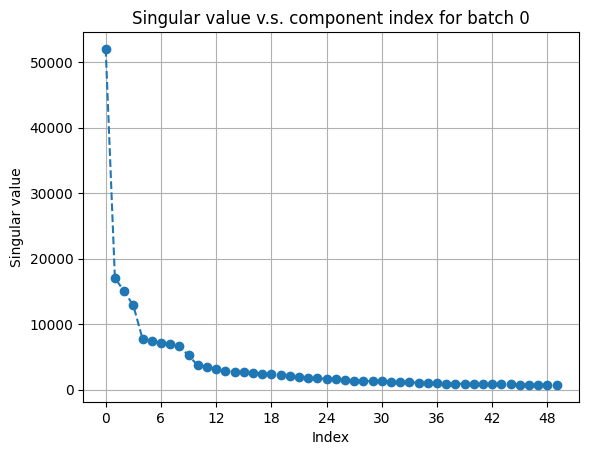

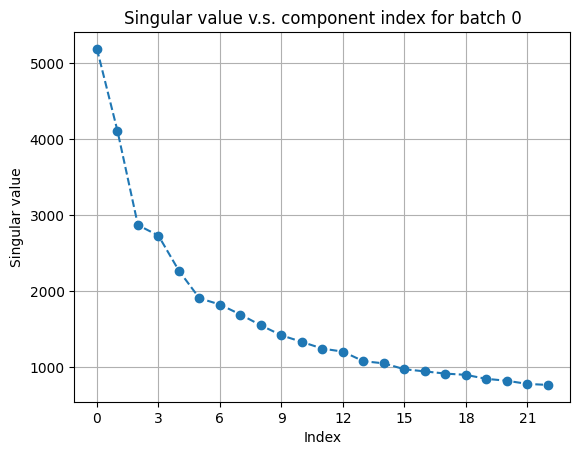

In [18]:
# Plot singular values to determine SVD components
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# plt.sca(axes[0])
fusor.plot_singular_values(target='active_arr1', n_components=50)
# axes[0].set_title('RNA Active - Singular Values')

# plt.sca(axes[1])
fusor.plot_singular_values(target='active_arr2', n_components=min(23, protein_active.shape[1]-1))
# axes[1].set_title('Protein Active - Singular Values')

# plt.tight_layout()
# plt.show()

In [19]:
# Set SVD components based on data dimensions
# NOTE: Parameters adjusted for 59-marker PhenoCycler dataset (vs original 26-marker CODEX)
n_prot_features = protein_active.shape[1]
n_rna_features = rna_active.shape[1]
n_shared = rna_shared.shape[1]

# Graph construction: higher SVD for protein to capture richer 59-marker structure
svd_comp1_graph = min(50, n_rna_features - 1)  # RNA: increased from 40 to 50
svd_comp2_graph = min(30, n_prot_features - 1)  # Protein: increased from 15 to 30 for 59 markers

print(f"Graph construction SVD components:")
print(f"  RNA: {svd_comp1_graph}")
print(f"  Protein: {svd_comp2_graph}")
print(f"  (Protein features: {n_prot_features})")


Graph construction SVD components:
  RNA: 50
  Protein: 30
  (Protein features: 58)


In [20]:
# Construct graphs with automatic clustering
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_comp1_graph,
    svd_components2=svd_comp2_graph,
    resolution1=2.0,   # Higher resolution = more clusters = finer smoothing
    resolution2=2.0,
    resolution_tol=0.1,
    leiden_runs=1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


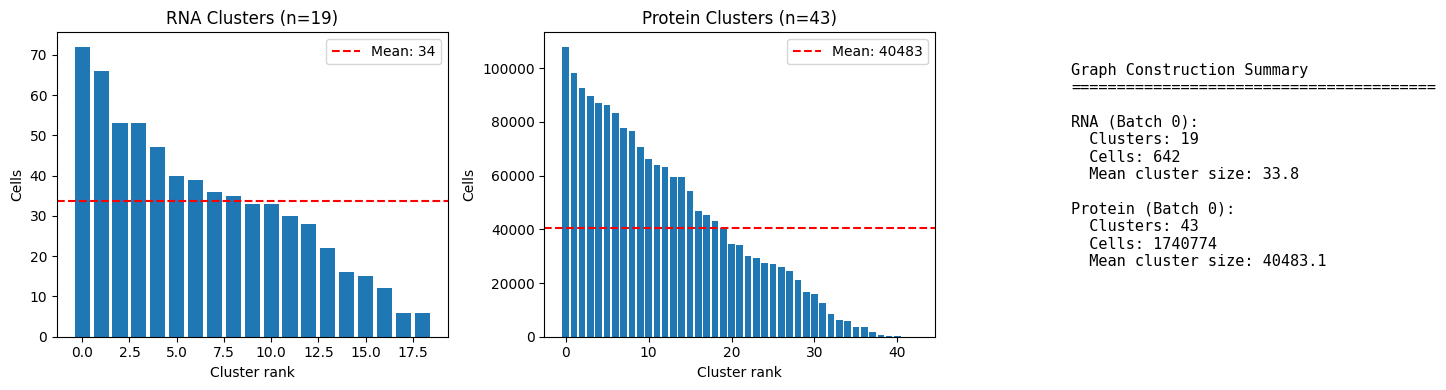

In [21]:
# Visualize clustering results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get cluster labels from first batch
labels1_b0 = fusor._labels1[0]
labels2_b0 = fusor._labels2[0]

# RNA cluster sizes
ax = axes[0]
unique, counts = np.unique(labels1_b0, return_counts=True)
ax.bar(range(len(counts)), sorted(counts, reverse=True))
ax.set_xlabel('Cluster rank')
ax.set_ylabel('Cells')
ax.set_title(f'RNA Clusters (n={len(unique)})')
ax.axhline(y=np.mean(counts), color='r', linestyle='--', label=f'Mean: {np.mean(counts):.0f}')
ax.legend()

# Protein cluster sizes
ax = axes[1]
unique, counts = np.unique(labels2_b0, return_counts=True)
ax.bar(range(len(counts)), sorted(counts, reverse=True))
ax.set_xlabel('Cluster rank')
ax.set_ylabel('Cells')
ax.set_title(f'Protein Clusters (n={len(unique)})')
ax.axhline(y=np.mean(counts), color='r', linestyle='--', label=f'Mean: {np.mean(counts):.0f}')
ax.legend()

# Summary stats
ax = axes[2]
ax.axis('off')
stats_text = f'''Graph Construction Summary
{"="*40}

RNA (Batch 0):
  Clusters: {len(np.unique(labels1_b0))}
  Cells: {len(labels1_b0)}
  Mean cluster size: {np.mean(np.bincount(labels1_b0)):.1f}

Protein (Batch 0):
  Clusters: {len(np.unique(labels2_b0))}
  Cells: {len(labels2_b0)}
  Mean cluster size: {np.mean(np.bincount(labels2_b0)):.1f}
'''
ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [22]:
# Find initial pivots with smoothing for weak linkage
# NOTE: Reduced SVD components (from 25/20) to prevent noise fitting in weak linkage scenario
# Initial matching uses ONLY shared features (~26), so fewer components = more robust seeds
svd_shared1 = min(20, n_shared - 1)  # Reduced from 25 to 20
svd_shared2 = min(18, n_shared - 1)  # Reduced from 20 to 18
print(f"Using {svd_shared1}/{svd_shared2} SVD components for shared features")
print(f"  (n_shared = {n_shared})")

fusor.find_initial_pivots(
    wt1=0.3,  # Smoothing weight
    wt2=0.3,
    svd_components1=svd_shared1,
    svd_components2=svd_shared2,
    verbose=True
)


Using 20/18 SVD components for shared features
  (n_shared = 43)
Now at batch 0<->0...
Done!


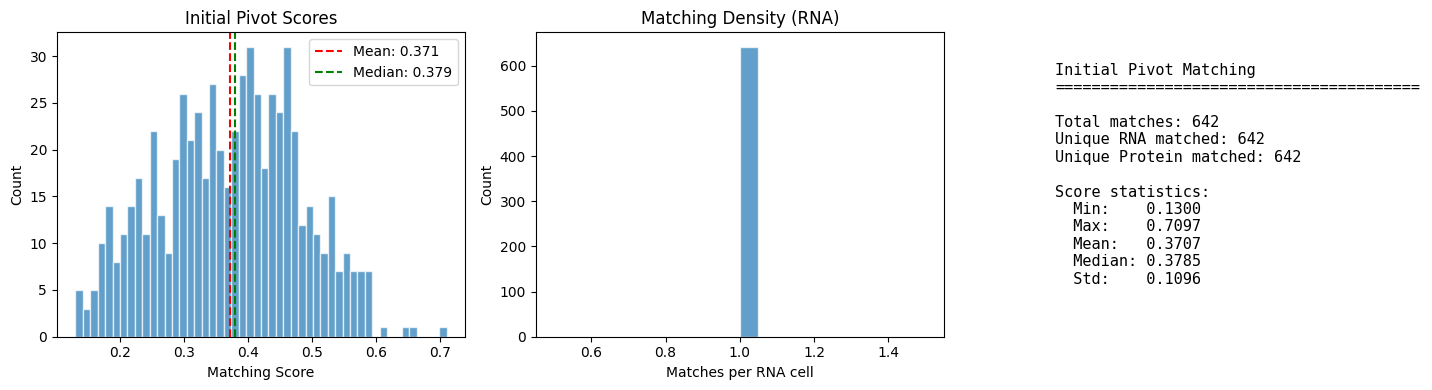

In [23]:
# Visualize initial pivot matching
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get initial matching from first batch
init_match = fusor._init_matching[0]
init_rows, init_cols, init_scores = init_match

# Score distribution
ax = axes[0]
ax.hist(init_scores, bins=50, edgecolor='white', alpha=0.7)
ax.axvline(np.mean(init_scores), color='r', linestyle='--', 
           label=f'Mean: {np.mean(init_scores):.3f}')
ax.axvline(np.median(init_scores), color='g', linestyle='--',
           label=f'Median: {np.median(init_scores):.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Initial Pivot Scores')
ax.legend()

# Matches per RNA cell
ax = axes[1]
matches_per_rna = np.bincount(init_rows)
ax.hist(matches_per_rna[matches_per_rna > 0], bins=20, edgecolor='white', alpha=0.7)
ax.set_xlabel('Matches per RNA cell')
ax.set_ylabel('Count')
ax.set_title('Matching Density (RNA)')

# Summary
ax = axes[2]
ax.axis('off')
n_rna_matched = len(np.unique(init_rows))
n_prot_matched = len(np.unique(init_cols))
stats = f'''Initial Pivot Matching
{"="*40}

Total matches: {len(init_scores):,}
Unique RNA matched: {n_rna_matched:,}
Unique Protein matched: {n_prot_matched:,}

Score statistics:
  Min:    {np.min(init_scores):.4f}
  Max:    {np.max(init_scores):.4f}
  Mean:   {np.mean(init_scores):.4f}
  Median: {np.median(init_scores):.4f}
  Std:    {np.std(init_scores):.4f}
'''
ax.text(0.1, 0.9, stats, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

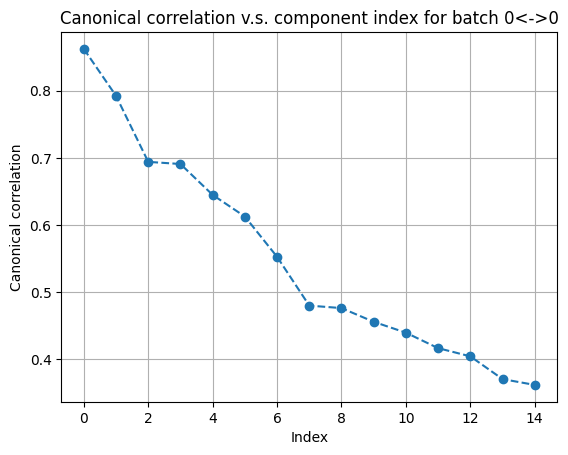

In [24]:
# Check canonical correlations
# Use same SVD limits as refine_pivots
cca_comp_check = min(15, n_prot_features - 1)
fusor.plot_canonical_correlations(
    svd_components1=min(50, n_rna_features - 1),   # Match refine_pivots
    svd_components2=min(35, n_prot_features - 1),  # Match refine_pivots
    cca_components=cca_comp_check
)


In [25]:
# Refine pivots using CCA
# CRITICAL: CCA component selection for 59-marker dataset
# Too many components = overfitting, especially with more protein features than RNA samples
# Rule: min(n_shared - 1, sqrt(n_protein_active) + 1, hard_cap)

n_prot_active = n_prot_features - n_shared  # Active protein features not in shared set
cca_components = min(
    n_shared - 1,                    # Can't exceed shared features
    int(np.sqrt(n_prot_active)) + 1, # sqrt rule for overfitting prevention
    12                               # Hard cap (increased from previous 25 which was too high)
)
cca_components = max(5, cca_components)  # At least 5 components

print(f"CCA components: {cca_components}")
print(f"  (n_shared={n_shared}, n_prot_active={n_prot_active}, sqrt rule={int(np.sqrt(n_prot_active))+1})")

# SVD before CCA: reduce dimensionality to prevent CCA overfitting
svd_cca_rna = min(50, n_rna_features - 1)     # Increased from 40 to 50
svd_cca_prot = min(35, n_prot_features - 1)   # NEW: limit protein SVD (was None = keep all)

print(f"SVD before CCA: RNA={svd_cca_rna}, Protein={svd_cca_prot}")

fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=svd_cca_rna,
    svd_components2=svd_cca_prot,  # Now limited instead of None
    cca_components=cca_components,
    n_iters=1,
    filter_prop=0.0,
    verbose=True
)


CCA components: 5
  (n_shared=43, n_prot_active=15, sqrt rule=4)
SVD before CCA: RNA=50, Protein=35
Now at batch 0<->0...
Done!


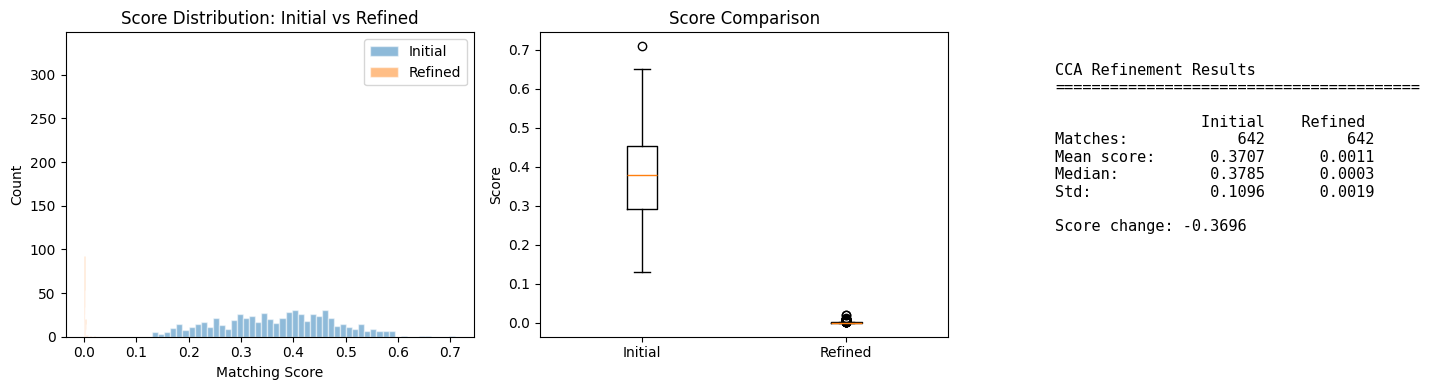

In [26]:
# Compare initial vs refined matching
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get refined matching
refined_match = fusor._refined_matching[0]
ref_rows, ref_cols, ref_scores = refined_match

# Score comparison
ax = axes[0]
ax.hist(init_scores, bins=50, alpha=0.5, label='Initial', edgecolor='white')
ax.hist(ref_scores, bins=50, alpha=0.5, label='Refined', edgecolor='white')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score Distribution: Initial vs Refined')
ax.legend()

# Score improvement
ax = axes[1]
ax.boxplot([init_scores, ref_scores], labels=['Initial', 'Refined'])
ax.set_ylabel('Score')
ax.set_title('Score Comparison')

# Summary
ax = axes[2]
ax.axis('off')
stats = f'''CCA Refinement Results
{"="*40}

                Initial    Refined
Matches:     {len(init_scores):>10,}  {len(ref_scores):>10,}
Mean score:  {np.mean(init_scores):>10.4f}  {np.mean(ref_scores):>10.4f}
Median:      {np.median(init_scores):>10.4f}  {np.median(ref_scores):>10.4f}
Std:         {np.std(init_scores):>10.4f}  {np.std(ref_scores):>10.4f}

Score change: {np.mean(ref_scores) - np.mean(init_scores):+.4f}
'''
ax.text(0.1, 0.9, stats, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

GMM Analysis of Pivot Matching Scores
Mode 1 (good): mean=0.001, std=0.001, weight=94.8%
Mode 2 (bad):  mean=0.007, std=0.004, weight=5.2%

Recommended filter_prop: 0.05 (fraction in bad mode)
Threshold between modes: 0.004


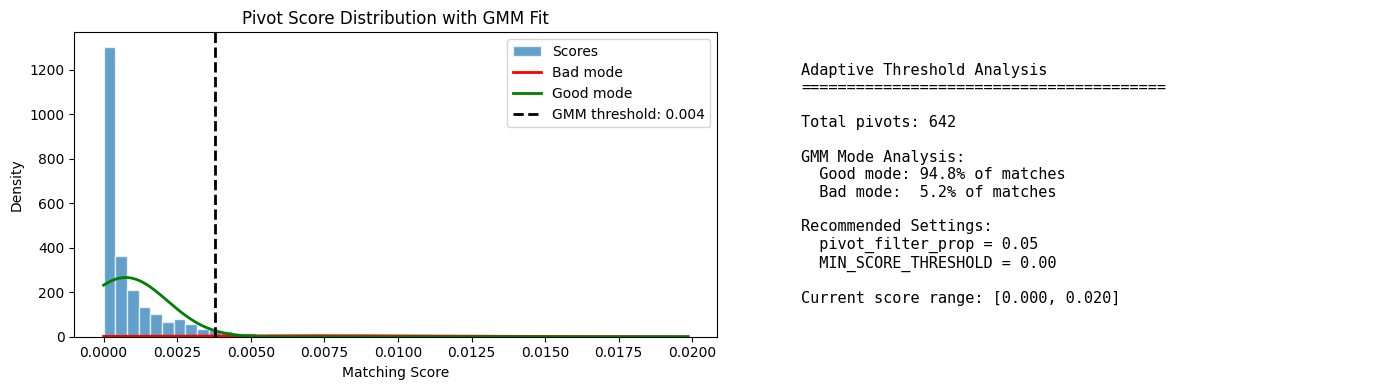

In [37]:
# Analyze pivot score distribution with Gaussian Mixture Model
# This helps identify bimodal distribution and set adaptive thresholds
from sklearn.mixture import GaussianMixture

# Get pivot matching scores from refined matching
pivot_match = fusor._refined_matching[0]  # First batch
pivot_scores = np.array(pivot_match[2])

# Fit Gaussian Mixture to detect two modes
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(pivot_scores.reshape(-1, 1))
means = gmm.means_.flatten()
weights = gmm.weights_
stds = np.sqrt(gmm.covariances_.flatten())

# Identify good vs bad mode (lower score = better match for distance-based)
good_mode_idx = np.argmin(means)
bad_mode_idx = np.argmax(means)

print("GMM Analysis of Pivot Matching Scores")
print("=" * 50)
print(f"Mode 1 (good): mean={means[good_mode_idx]:.3f}, std={stds[good_mode_idx]:.3f}, weight={weights[good_mode_idx]:.1%}")
print(f"Mode 2 (bad):  mean={means[bad_mode_idx]:.3f}, std={stds[bad_mode_idx]:.3f}, weight={weights[bad_mode_idx]:.1%}")

# Threshold at midpoint between modes
gmm_threshold = (means[0] + means[1]) / 2
bad_mode_fraction = weights[bad_mode_idx]

print(f"\nRecommended filter_prop: {bad_mode_fraction:.2f} (fraction in bad mode)")
print(f"Threshold between modes: {gmm_threshold:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram with GMM fit
ax = axes[0]
x = np.linspace(pivot_scores.min(), pivot_scores.max(), 200)
ax.hist(pivot_scores, bins=50, density=True, alpha=0.7, edgecolor='white', label='Scores')

# Plot GMM components
from scipy.stats import norm
for i in range(2):
    color = 'green' if i == good_mode_idx else 'red'
    label = 'Good mode' if i == good_mode_idx else 'Bad mode'
    ax.plot(x, weights[i] * norm.pdf(x, means[i], stds[i]), 
            color=color, linewidth=2, label=label)

ax.axvline(gmm_threshold, color='black', linestyle='--', linewidth=2, label=f'GMM threshold: {gmm_threshold:.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Density')
ax.set_title('Pivot Score Distribution with GMM Fit')
ax.legend()

# Score ranges
ax = axes[1]
ax.axis('off')
summary = f'''Adaptive Threshold Analysis
{"="*40}

Total pivots: {len(pivot_scores):,}

GMM Mode Analysis:
  Good mode: {weights[good_mode_idx]:.1%} of matches
  Bad mode:  {weights[bad_mode_idx]:.1%} of matches

Recommended Settings:
  pivot_filter_prop = {bad_mode_fraction:.2f}
  MIN_SCORE_THRESHOLD = {gmm_threshold:.2f}

Current score range: [{pivot_scores.min():.3f}, {pivot_scores.max():.3f}]
'''
ax.text(0.1, 0.9, summary, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [38]:
# Filter bad pivots
# NOTE: Using conservative filtering (20%) to retain more matches
# Increase filter_prop if too many low-quality matches remain
pivot_filter_prop = 0.2  # Remove bottom 20%

fusor.filter_bad_matches(
    target='pivot',
    filter_prop=pivot_filter_prop,
    verbose=True
)

print(f"\nFiltered {pivot_filter_prop*100:.0f}% of lowest-scoring pivots")

Begin filtering...
Now at batch 0<->0...
321/642 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
666/1284 cells in arr1 are selected as pivots.
321/1740774 cells in arr2 are selected as pivots.
Done!

Filtered 50% of lowest-scoring pivots


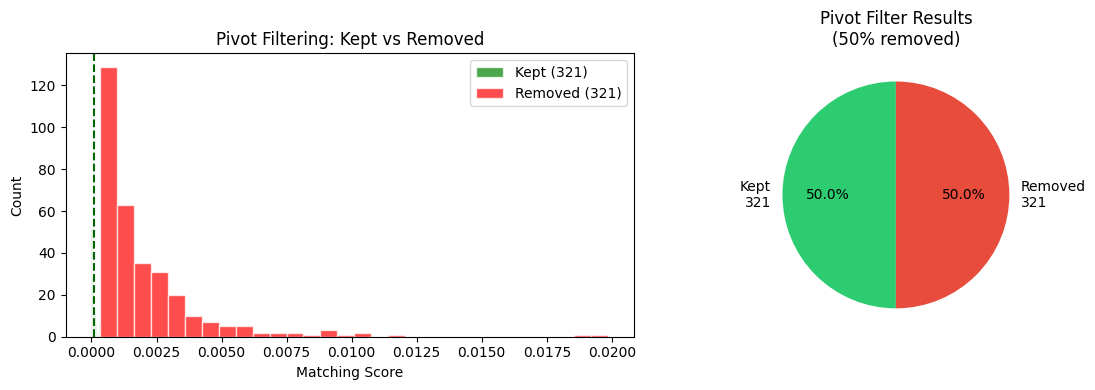

Pivot filtering: 321 kept, 321 removed
Mean score - Kept: 0.0001, Removed: 0.0020


In [39]:
# Visualize pivot filtering results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Get remaining indices
remaining_idx = fusor._remaining_indices_in_refined_matching[0]
kept_scores = ref_scores[remaining_idx]
removed_scores = np.delete(ref_scores, remaining_idx)

# Score distributions: kept vs removed
ax = axes[0]
ax.hist(kept_scores, bins=30, alpha=0.7, label=f'Kept ({len(kept_scores)})', color='green', edgecolor='white')
if len(removed_scores) > 0:
    ax.hist(removed_scores, bins=30, alpha=0.7, label=f'Removed ({len(removed_scores)})', color='red', edgecolor='white')
ax.axvline(np.mean(kept_scores), color='darkgreen', linestyle='--')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Pivot Filtering: Kept vs Removed')
ax.legend()

# Summary pie chart
ax = axes[1]
sizes = [len(kept_scores), len(removed_scores)]
labels = [f'Kept\n{len(kept_scores):,}', f'Removed\n{len(removed_scores):,}']
colors = ['#2ecc71', '#e74c3c']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
pct_removed = 100 * len(removed_scores) / (len(kept_scores) + len(removed_scores))
ax.set_title(f'Pivot Filter Results\n({pct_removed:.0f}% removed)')

plt.tight_layout()
plt.show()

print(f"Pivot filtering: {len(kept_scores):,} kept, {len(removed_scores):,} removed")
if len(removed_scores) > 0:
    print(f"Mean score - Kept: {np.mean(kept_scores):.4f}, Removed: {np.mean(removed_scores):.4f}")
else:
    print(f"Mean score - Kept: {np.mean(kept_scores):.4f}")


In [29]:
# Propagate to all cells
# Use same SVD limits as refine_pivots for consistency
fusor.propagate(
    svd_components1=min(50, n_rna_features - 1),   # Increased from 40 to 50
    svd_components2=min(35, n_prot_features - 1),  # NEW: limit protein SVD (was None)
    wt1=0.7,
    wt2=0.7,
    verbose=True
)


Now at batch 0<->0...
Done!


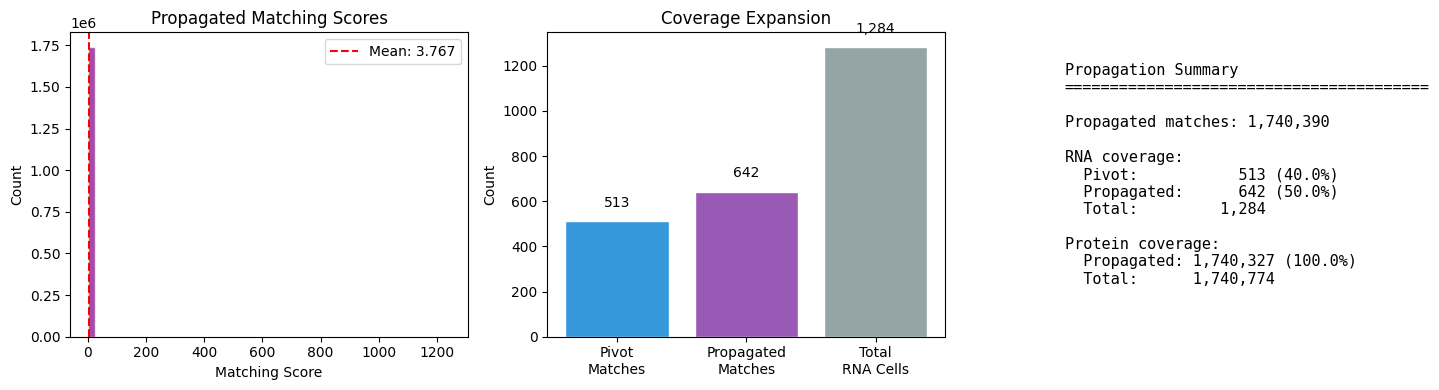

In [30]:
# Visualize propagation results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get propagated matching
prop_match = fusor._propagated_matching[0]
prop_rows, prop_cols, prop_scores = prop_match

# Score distribution
ax = axes[0]
ax.hist(prop_scores, bins=50, edgecolor='white', alpha=0.7, color='purple')
ax.axvline(np.mean(prop_scores), color='r', linestyle='--',
           label=f'Mean: {np.mean(prop_scores):.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Propagated Matching Scores')
ax.legend()

# Coverage: pivot vs propagated
ax = axes[1]
pivot_rna = len(np.unique(ref_rows[remaining_idx]))
prop_rna = len(np.unique(prop_rows))
total_rna = rna_active.shape[0]

categories = ['Pivot\nMatches', 'Propagated\nMatches', 'Total\nRNA Cells']
values = [pivot_rna, prop_rna, total_rna]
colors = ['#3498db', '#9b59b6', '#95a5a6']
bars = ax.bar(categories, values, color=colors, edgecolor='white')
ax.set_ylabel('Count')
ax.set_title('Coverage Expansion')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:,}', ha='center', va='bottom', fontsize=10)

# Summary
ax = axes[2]
ax.axis('off')
prop_prot = len(np.unique(prop_cols))
total_prot = protein_active.shape[0]
stats = f'''Propagation Summary
{"="*40}

Propagated matches: {len(prop_scores):,}

RNA coverage:
  Pivot:      {pivot_rna:>8,} ({100*pivot_rna/total_rna:.1f}%)
  Propagated: {prop_rna:>8,} ({100*prop_rna/total_rna:.1f}%)
  Total:      {total_rna:>8,}

Protein coverage:
  Propagated: {prop_prot:>8,} ({100*prop_prot/total_prot:.1f}%)
  Total:      {total_prot:>8,}
'''
ax.text(0.1, 0.9, stats, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [31]:
# Filter propagated matches
# NOTE: Using conservative filtering (10%) to maximize coverage
propagate_filter_prop = 0.1  # Remove bottom 10%

fusor.filter_bad_matches(
    target='propagated',
    filter_prop=propagate_filter_prop,
    verbose=True
)

print(f"\nFiltered {propagate_filter_prop*100:.0f}% of lowest-scoring propagated matches")

Begin filtering...
Now at batch 0<->0...
1566351/1740390 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!

Filtered 10% of lowest-scoring propagated matches


In [32]:
# Get full matching - RNA-CENTRIC
# order=(1,2) ensures each RNA cell gets at least one protein match
# This gives ~1,284 matches (one per RNA) instead of ~1.7M (one per protein)
full_matching = fusor.get_matching(order=(1, 2), target='full_data')

print(f"\nMaxFuse Full matching results (RNA-centric):")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells: {len(np.unique(full_matching[1]))}")
print(f"  Score range: [{min(full_matching[2]):.3f}, {max(full_matching[2]):.3f}]")


MaxFuse Full matching results:
  Total matches: 1566862
  Unique RNA cells: 994
  Unique Protein cells: 1566862
  Score range: [-0.998, 1.000]


Score threshold filtering (min score >= 0.0):
  Original matches: 1,566,862
  Removed (score < 0.0): 126,541 (8.1%)
  Remaining matches: 1,440,321

Score statistics after filtering:
  Min:    0.0000
  Max:    1.0000
  Mean:   0.7038
  Median: 0.7932


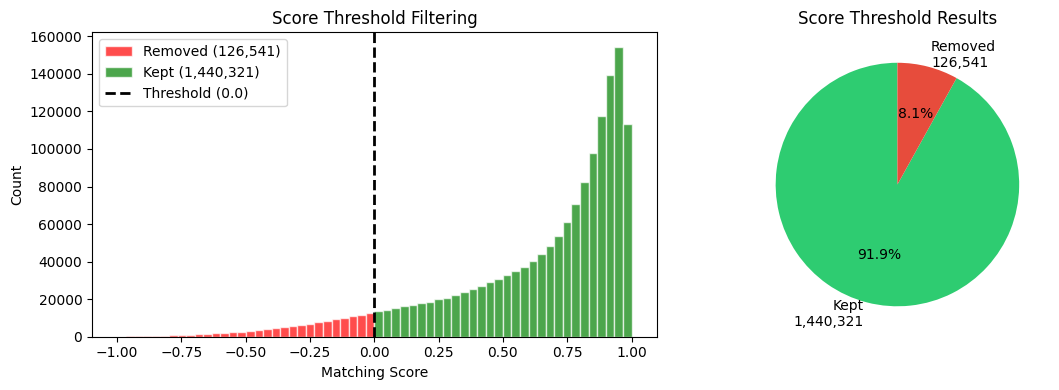

In [33]:
# Apply score threshold to remove negative/low-quality matches
MIN_SCORE_THRESHOLD = 0.0  # Remove anti-correlated matches only

# Get original stats
n_original = len(full_matching[0])
scores = np.array(full_matching[2])

# Filter by threshold
mask = scores >= MIN_SCORE_THRESHOLD
full_matching_filtered = (
    np.array(full_matching[0])[mask],
    np.array(full_matching[1])[mask],
    scores[mask]
)

n_filtered = len(full_matching_filtered[0])
n_removed = n_original - n_filtered

print(f"Score threshold filtering (min score >= {MIN_SCORE_THRESHOLD}):")
print(f"  Original matches: {n_original:,}")
print(f"  Removed (score < {MIN_SCORE_THRESHOLD}): {n_removed:,} ({100*n_removed/n_original:.1f}%)")
print(f"  Remaining matches: {n_filtered:,}")
print(f"")
print(f"Score statistics after filtering:")
print(f"  Min:    {np.min(full_matching_filtered[2]):.4f}")
print(f"  Max:    {np.max(full_matching_filtered[2]):.4f}")
print(f"  Mean:   {np.mean(full_matching_filtered[2]):.4f}")
print(f"  Median: {np.median(full_matching_filtered[2]):.4f}")

# Update full_matching to use filtered version
full_matching = full_matching_filtered

# Visualize what was removed
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
if n_removed > 0:
    ax.hist(scores[~mask], bins=30, alpha=0.7, color='red', label=f'Removed ({n_removed:,})', edgecolor='white')
ax.hist(scores[mask], bins=30, alpha=0.7, color='green', label=f'Kept ({n_filtered:,})', edgecolor='white')
ax.axvline(MIN_SCORE_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({MIN_SCORE_THRESHOLD})')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score Threshold Filtering')
ax.legend()

ax = axes[1]
if n_removed > 0:
    sizes = [n_filtered, n_removed]
    colors = ['#2ecc71', '#e74c3c']
    labels = [f'Kept\n{n_filtered:,}', f'Removed\n{n_removed:,}']
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Score Threshold Results')
else:
    ax.text(0.5, 0.5, f'All {n_filtered:,} matches\nkept (score >= {MIN_SCORE_THRESHOLD})', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))
    ax.set_title('Score Threshold Results')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Verify matching cardinality (RNA-centric approach)
print("=" * 60)
print("MATCHING CARDINALITY VERIFICATION (RNA-CENTRIC)")
print("=" * 60)

n_total_matches = len(full_matching[0])
n_unique_rna = len(np.unique(full_matching[0]))
n_unique_protein = len(np.unique(full_matching[1]))

print(f"Total matches: {n_total_matches:,}")
print(f"Unique RNA matched: {n_unique_rna:,} / {rna_active.shape[0]} ({100*n_unique_rna/rna_active.shape[0]:.1f}%)")
print(f"Unique protein matched: {n_unique_protein:,} / {protein_active.shape[0]} ({100*n_unique_protein/protein_active.shape[0]:.1f}%)")
print(f"")
print(f"Score range: [{full_matching[2].min():.3f}, {full_matching[2].max():.3f}]")
print(f"Mean score: {full_matching[2].mean():.3f}")
print(f"")

# With RNA-centric matching, we expect ~1 match per RNA cell
avg_matches_per_rna = n_total_matches / n_unique_rna if n_unique_rna > 0 else 0
print(f"Avg matches per RNA: {avg_matches_per_rna:.1f}")

# Check RNA coverage
rna_coverage = n_unique_rna / rna_active.shape[0] * 100
if rna_coverage >= 90:
    print(f"\n✓ Good RNA coverage ({rna_coverage:.1f}%)")
else:
    print(f"\n⚠️  Low RNA coverage ({rna_coverage:.1f}%) - some RNA cells unmatched")

UNMATCHED RNA CELL ANALYSIS

RNA Cell Coverage:
  Matched:   993 (77.3%)
  Unmatched: 291 (22.7%)
  Total:     1,284


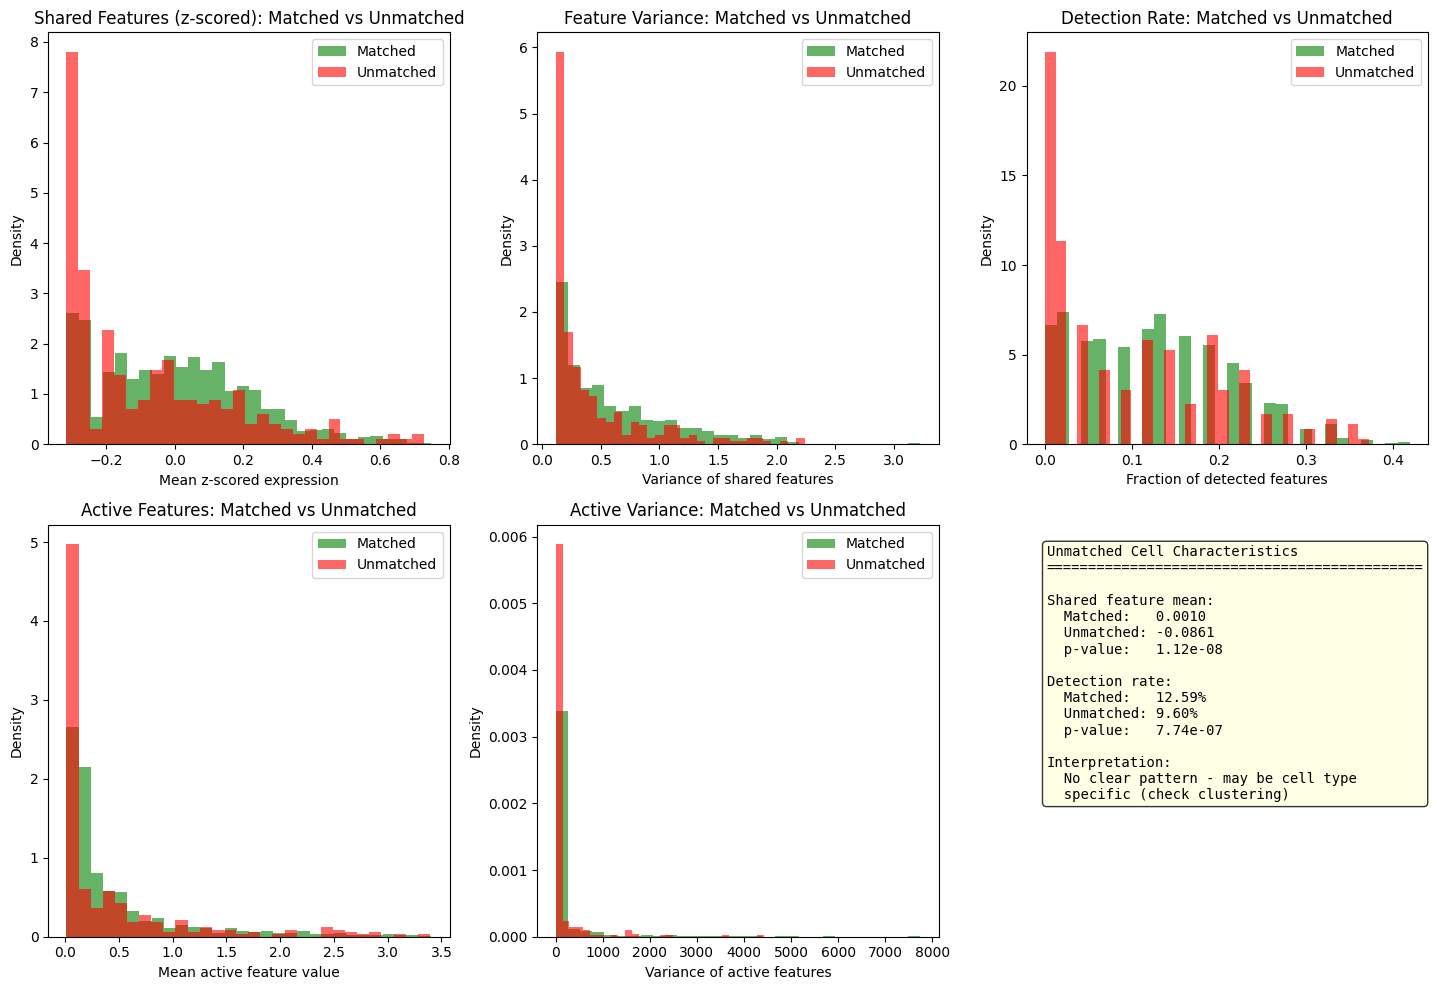


Unmatched RNA cell indices saved to 'unmatched_rna_indices'
Use these indices to investigate in notebook 3 (visualization)


In [34]:
# Investigate unmatched RNA cells
# Validate that score filtering was applied (cell 57 must run first)
assert np.min(full_matching[2]) >= MIN_SCORE_THRESHOLD, \
    f"Run the score filtering cell first! Found scores below {MIN_SCORE_THRESHOLD} in full_matching."

print("=" * 60)
print("UNMATCHED RNA CELL ANALYSIS")
print("=" * 60)

# Find matched and unmatched RNA cells
matched_rna_idx = np.unique(full_matching[0])
all_rna_idx = np.arange(rna_active.shape[0])
unmatched_rna_idx = np.setdiff1d(all_rna_idx, matched_rna_idx)

n_matched = len(matched_rna_idx)
n_unmatched = len(unmatched_rna_idx)
n_total = rna_active.shape[0]

print(f"\nRNA Cell Coverage:")
print(f"  Matched:   {n_matched:,} ({100*n_matched/n_total:.1f}%)")
print(f"  Unmatched: {n_unmatched:,} ({100*n_unmatched/n_total:.1f}%)")
print(f"  Total:     {n_total:,}")

# Save unmatched indices for further analysis
unmatched_rna_indices = unmatched_rna_idx

if n_unmatched == 0:
    print("\n*** All RNA cells matched! ***")
    print("No unmatched analysis needed.")
else:
    # Compare feature distributions: matched vs unmatched
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Shared feature means
    ax = axes[0, 0]
    matched_shared_mean = rna_shared[matched_rna_idx].mean(axis=1)
    unmatched_shared_mean = rna_shared[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_shared_mean, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_shared_mean, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Mean z-scored expression')
    ax.set_ylabel('Density')
    ax.set_title('Shared Features (z-scored): Matched vs Unmatched')
    ax.legend()

    # Shared feature variance
    ax = axes[0, 1]
    matched_shared_var = rna_shared[matched_rna_idx].var(axis=1)
    unmatched_shared_var = rna_shared[unmatched_rna_idx].var(axis=1)
    ax.hist(matched_shared_var, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_shared_var, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Variance of shared features')
    ax.set_ylabel('Density')
    ax.set_title('Feature Variance: Matched vs Unmatched')
    ax.legend()

    # Detection rate (non-zero features)
    ax = axes[0, 2]
    # Use detection mask from normalization (non-zero after log1p)
    matched_detection = rna_detection_mask[matched_rna_idx].mean(axis=1)
    unmatched_detection = rna_detection_mask[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_detection, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_detection, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Fraction of detected features')
    ax.set_ylabel('Density')
    ax.set_title('Detection Rate: Matched vs Unmatched')
    ax.legend()

    # Active feature mean
    ax = axes[1, 0]
    matched_active_mean = rna_active[matched_rna_idx].mean(axis=1)
    unmatched_active_mean = rna_active[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_active_mean, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_active_mean, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Mean active feature value')
    ax.set_ylabel('Density')
    ax.set_title('Active Features: Matched vs Unmatched')
    ax.legend()

    # Active feature variance  
    ax = axes[1, 1]
    matched_active_var = rna_active[matched_rna_idx].var(axis=1)
    unmatched_active_var = rna_active[unmatched_rna_idx].var(axis=1)
    ax.hist(matched_active_var, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_active_var, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Variance of active features')
    ax.set_ylabel('Density')
    ax.set_title('Active Variance: Matched vs Unmatched')
    ax.legend()

    # Summary statistics
    ax = axes[1, 2]
    ax.axis('off')

    # Statistical comparison
    from scipy import stats
    t_stat_shared, p_shared = stats.ttest_ind(matched_shared_mean, unmatched_shared_mean)
    t_stat_detect, p_detect = stats.ttest_ind(matched_detection, unmatched_detection)

    summary = f"""Unmatched Cell Characteristics
{"="*45}

Shared feature mean:
  Matched:   {np.mean(matched_shared_mean):.4f}
  Unmatched: {np.mean(unmatched_shared_mean):.4f}
  p-value:   {p_shared:.2e}

Detection rate:
  Matched:   {np.mean(matched_detection):.2%}
  Unmatched: {np.mean(unmatched_detection):.2%}
  p-value:   {p_detect:.2e}

Interpretation:
"""

    if np.mean(unmatched_detection) < np.mean(matched_detection) - 0.05:
        summary += "  Unmatched cells have LOWER detection\n"
        summary += "  (sparse profiles harder to match)"
    elif np.mean(unmatched_shared_mean) < np.mean(matched_shared_mean) - 0.1:
        summary += "  Unmatched cells have LOWER expression\n"
        summary += "  (low signal harder to match)"
    else:
        summary += "  No clear pattern - may be cell type\n"
        summary += "  specific (check clustering)"

    ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    plt.tight_layout()
    plt.show()

print(f"\nUnmatched RNA cell indices saved to 'unmatched_rna_indices'")
print(f"Use these indices to investigate in notebook 3 (visualization)")


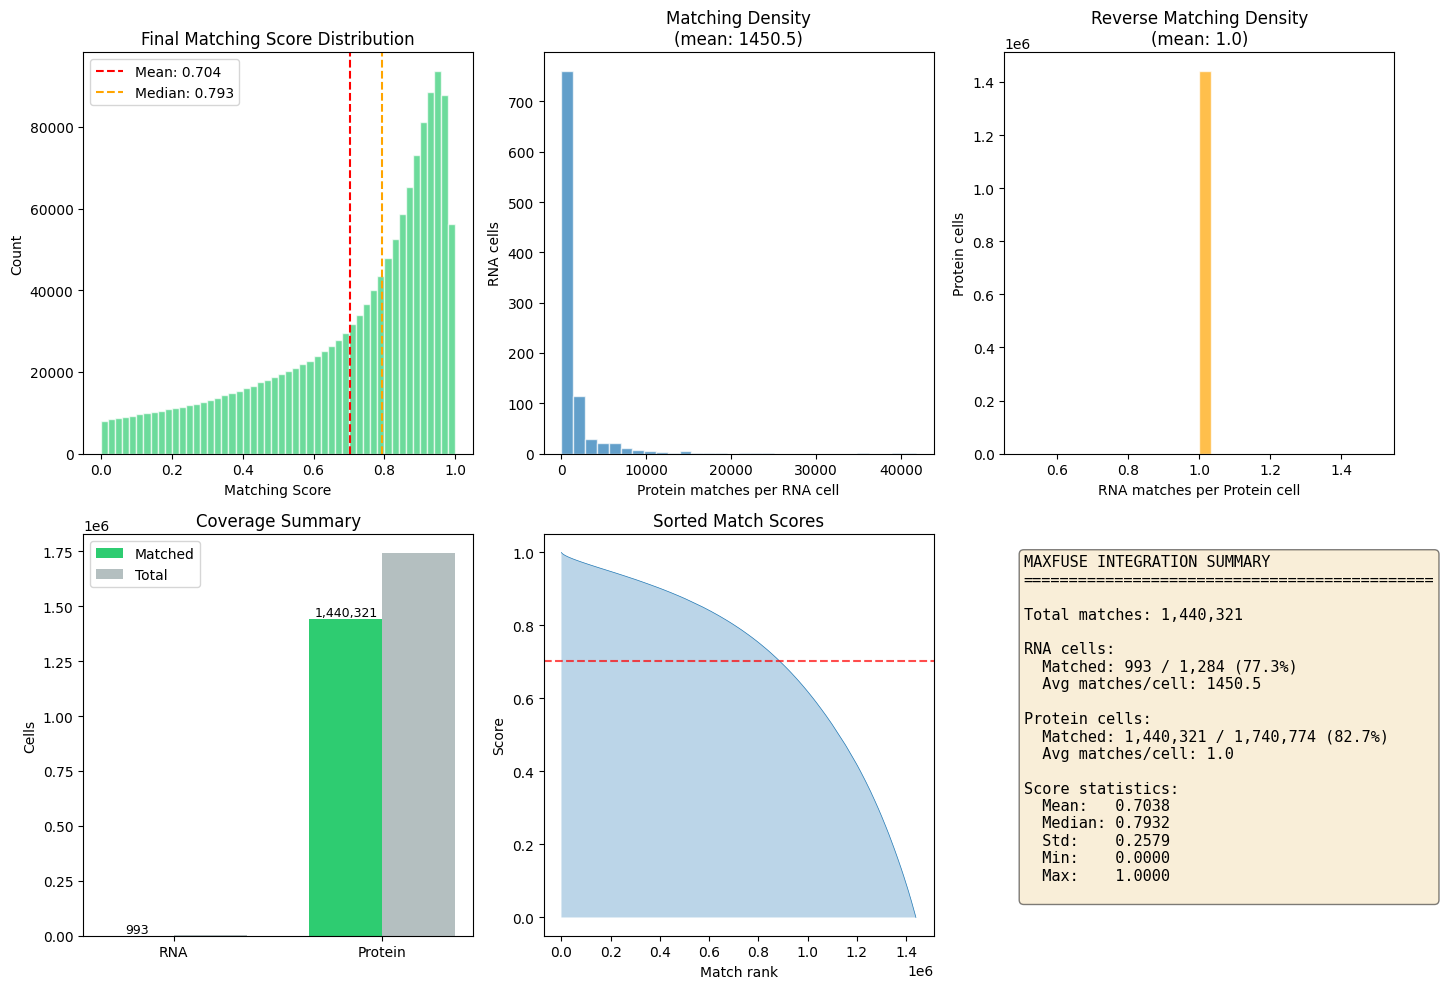

In [35]:
# Comprehensive final matching visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Score distribution
ax = axes[0, 0]
ax.hist(full_matching[2], bins=50, edgecolor='white', alpha=0.7, color='#2ecc71')
ax.axvline(np.mean(full_matching[2]), color='r', linestyle='--',
           label=f'Mean: {np.mean(full_matching[2]):.3f}')
ax.axvline(np.median(full_matching[2]), color='orange', linestyle='--',
           label=f'Median: {np.median(full_matching[2]):.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Final Matching Score Distribution')
ax.legend()

# Matches per RNA cell
ax = axes[0, 1]
rna_match_counts = np.bincount(full_matching[0], minlength=rna_active.shape[0])
ax.hist(rna_match_counts[rna_match_counts > 0], bins=30, edgecolor='white', alpha=0.7)
ax.set_xlabel('Protein matches per RNA cell')
ax.set_ylabel('RNA cells')
ax.set_title(f'Matching Density\n(mean: {np.mean(rna_match_counts[rna_match_counts > 0]):.1f})')

# Matches per Protein cell
ax = axes[0, 2]
prot_match_counts = np.bincount(full_matching[1], minlength=protein_active.shape[0])
ax.hist(prot_match_counts[prot_match_counts > 0], bins=30, edgecolor='white', alpha=0.7, color='orange')
ax.set_xlabel('RNA matches per Protein cell')
ax.set_ylabel('Protein cells')
ax.set_title(f'Reverse Matching Density\n(mean: {np.mean(prot_match_counts[prot_match_counts > 0]):.1f})')

# Coverage summary
ax = axes[1, 0]
n_rna_matched = len(np.unique(full_matching[0]))
n_prot_matched = len(np.unique(full_matching[1]))
categories = ['RNA', 'Protein']
matched = [n_rna_matched, n_prot_matched]
total = [rna_active.shape[0], protein_active.shape[0]]
x = np.arange(len(categories))
width = 0.35
bars1 = ax.bar(x - width/2, matched, width, label='Matched', color='#2ecc71')
bars2 = ax.bar(x + width/2, total, width, label='Total', color='#95a5a6', alpha=0.7)
ax.set_ylabel('Cells')
ax.set_title('Coverage Summary')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
for bar, val in zip(bars1, matched):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:,}', ha='center', va='bottom', fontsize=9)

# Score vs index (quality across matches)
ax = axes[1, 1]
sorted_scores = np.sort(full_matching[2])[::-1]
ax.plot(sorted_scores, linewidth=0.5)
ax.axhline(np.mean(full_matching[2]), color='r', linestyle='--', alpha=0.7)
ax.set_xlabel('Match rank')
ax.set_ylabel('Score')
ax.set_title('Sorted Match Scores')
ax.fill_between(range(len(sorted_scores)), sorted_scores, alpha=0.3)

# Final summary text
ax = axes[1, 2]
ax.axis('off')
coverage_rna = 100 * n_rna_matched / rna_active.shape[0]
coverage_prot = 100 * n_prot_matched / protein_active.shape[0]
summary = f'''MAXFUSE INTEGRATION SUMMARY
{"="*45}

Total matches: {len(full_matching[0]):,}

RNA cells:
  Matched: {n_rna_matched:,} / {rna_active.shape[0]:,} ({coverage_rna:.1f}%)
  Avg matches/cell: {len(full_matching[0])/n_rna_matched:.1f}

Protein cells:
  Matched: {n_prot_matched:,} / {protein_active.shape[0]:,} ({coverage_prot:.1f}%)
  Avg matches/cell: {len(full_matching[0])/n_prot_matched:.1f}

Score statistics:
  Mean:   {np.mean(full_matching[2]):.4f}
  Median: {np.median(full_matching[2]):.4f}
  Std:    {np.std(full_matching[2]):.4f}
  Min:    {np.min(full_matching[2]):.4f}
  Max:    {np.max(full_matching[2]):.4f}
'''
ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Save Integration Results

Save integration outputs for use in subsequent visualization notebooks.

In [36]:
# Save integration results to results directory
import os
import pickle
from datetime import datetime
import json as json_module

# Create results directory
results_dir = '../results/2_integration'
os.makedirs(results_dir, exist_ok=True)

# Save matching results (filtered by score threshold)
matching_data = {
    'rna_indices': full_matching[0],
    'protein_indices': full_matching[1],
    'scores': full_matching[2]
}
with open(f'{results_dir}/maxfuse_matching.pkl', 'wb') as f:
    pickle.dump(matching_data, f)
print(f'Saved MaxFuse matching: {len(full_matching[0]):,} matches')

# Save as CSV for easy inspection
matching_df = pd.DataFrame({
    'rna_idx': full_matching[0],
    'protein_idx': full_matching[1],
    'score': full_matching[2]
})
matching_df.to_csv(f'{results_dir}/maxfuse_matching.csv', index=False)

# Save unmatched RNA indices for further analysis
np.save(f'{results_dir}/unmatched_rna_indices.npy', unmatched_rna_indices)
print(f'Saved unmatched RNA indices: {len(unmatched_rna_indices):,} cells')

# Save normalized arrays used for integration
np.save(f'{results_dir}/rna_shared.npy', rna_shared)
np.save(f'{results_dir}/rna_active.npy', rna_active)
np.save(f'{results_dir}/protein_shared.npy', protein_shared)
np.save(f'{results_dir}/protein_active.npy', protein_active)
print(f'Saved normalized arrays')

# Save correspondence table
correspondence_df = pd.DataFrame(
    rna_protein_correspondence, 
    columns=['rna_gene', 'protein_marker']
)
correspondence_df.to_csv(f'{results_dir}/correspondence.csv', index=False)

# Save integration parameters
n_matched_rna = len(np.unique(full_matching[0]))
n_matched_prot = len(np.unique(full_matching[1]))
integration_params = {
    'timestamp': datetime.now().isoformat(),
    'method': 'maxfuse',
    'score_threshold': MIN_SCORE_THRESHOLD,
    'fusor_params': {
        'max_outward_size': max_outward,
        'matching_ratio': matching_ratio,
        'smoothing_method': fusor.method,
        'n_shared_features': rna_shared.shape[1],
        'cca_components': cca_components,
        'pivot_filter_prop': pivot_filter_prop,
        'propagate_filter_prop': propagate_filter_prop
    },
    'data_shapes': {
        'rna_cells': rna_active.shape[0],
        'protein_cells': protein_active.shape[0],
        'rna_active_features': rna_active.shape[1],
        'protein_active_features': protein_active.shape[1],
        'shared_features': rna_shared.shape[1]
    },
    'matching_stats': {
        'total_matches': len(full_matching[0]),
        'unique_rna_matched': n_matched_rna,
        'unique_protein_matched': n_matched_prot,
        'rna_coverage_pct': 100 * n_matched_rna / rna_active.shape[0],
        'protein_coverage_pct': 100 * n_matched_prot / protein_active.shape[0],
        'unmatched_rna_cells': len(unmatched_rna_indices),
        'mean_score': float(np.mean(full_matching[2])),
        'min_score': float(np.min(full_matching[2])),
        'max_score': float(np.max(full_matching[2]))
    }
}
with open(f'{results_dir}/integration_params.json', 'w') as f:
    json_module.dump(integration_params, f, indent=2)

print(f'\nAll outputs saved to {results_dir}/')
print(f'  - maxfuse_matching.pkl (pickle)')
print(f'  - maxfuse_matching.csv')
print(f'  - unmatched_rna_indices.npy')
print(f'  - rna_shared.npy, rna_active.npy')
print(f'  - protein_shared.npy, protein_active.npy')
print(f'  - correspondence.csv')
print(f'  - integration_params.json')
print(f'\nRun 3_visualization.ipynb next.')


Saved MaxFuse matching: 1,440,321 matches
Saved unmatched RNA indices: 291 cells
Saved normalized arrays

All outputs saved to results/2_integration/
  - maxfuse_matching.pkl (pickle)
  - maxfuse_matching.csv
  - unmatched_rna_indices.npy
  - rna_shared.npy, rna_active.npy
  - protein_shared.npy, protein_active.npy
  - correspondence.csv
  - integration_params.json

Run 3_visualization.ipynb next.
